In [54]:
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container { width: 95%;} div#menubar-container { width: 85%; } div#maintoolbar-container { width: 99%; } </style> """))
 
# %matplotlib inline

import os
import sys
import platform
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy
import flopy.utils.binaryfile as bf
from flopy.export.shapefile_utils import shp2recarray
from rasterio import Affine
from flopy.utils.reference import SpatialReference
from flopy.utils.postprocessing import get_transmissivities, get_water_table, get_gradients

import shapefile    # not used directly here but for some reason flopy needs this to do shapefile stuff and BTW its not import pyshp as you would think its import shapefile, dumb...
import pandas as pd
import fiona
from rasterio.features import rasterize
import rasterio
import rasterio.mask
import geopandas
from osgeo import gdal

#import simplekml
import ogr
from shapely.wkb import loads

from scipy.interpolate import interp2d
import scipy.optimize as opt


print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

#Set name of MODFLOW exe
#  assumes executable is in users path statement
exe_name = 'mf2005'
if platform.system() == 'Windows':
    exe_name = 'mf2005.exe'

workspace = os.path.join('Flo_py_wrkspace')
#make sure workspace directory exists
if not os.path.exists(workspace):
    os.makedirs(workspace)
    
figurespace = os.path.join(workspace, "Figures")
if not os.path.exists(figurespace):
    os.makedirs(figurespace)
    
WGS84UTM2S_string = 'PROJCS["WGS_1984_UTM_Zone_2S",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-171],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["Meter",1]]'
pd.set_option('display.max_rows', 75)

# define the spatial reference object 
model_epsg = 32702   # epsg code specifying coordinate reference system: in this case, UTM zone 2S, WGS 84, A proj4 string has also been fetched from <spatialreference.org> using the supplied epsg code.

# in line plotting and saving options. Change these to plot or not to plot inline
Plotnsave_plot = True
Plotnsave_save = True

3.8.2 | packaged by conda-forge | (default, Feb 28 2020, 16:38:51) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.18.1
matplotlib version: 3.1.3
flopy version: 3.3.0


# Model geometry notes


model boundaries square at 
X	Y
- 530200	8425825
- 537700	8425825
- 537700	8418325
- 530200	8418325

with length of 7500 m on both sides


next steps 
- try and just follow existing github model notebook 

Shapefile Boundaries: (530200.0, 8418325.0, 537700.0000000009, 8425825.000000002)
wrote Flo_py_wrkspace\Model_polyarea.shp
wrote Flo_py_wrkspace\Model_grid.shp


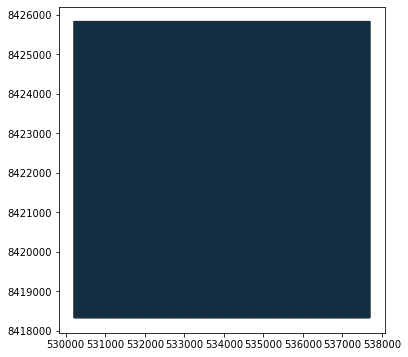

In [78]:
''' Define the number of layers, rows and columns.'''

ncol = 1500
nrow = 1500
nlay = 1

# model run times
nper = 1                     # Number of model stress periods (the default is 1)
perlen = [3650]              # An array of the stress period lengths in days separated by commas
nstp = [1]      # Number of time steps in each stress period (default is 1).
save_head = [3650]
steady = True
rotation = 0                             # rotation (positive counterclockwise)

# this cell inports the boundary shapefile to make the model around
ra = shp2recarray(os.path.join("..", "Data/Raw/GIS", 'model_square.shp'))
# these are the bondaries of the shapefile
shp_xmin = round(ra.geometry[0].bounds[0],1)
shp_ymin = round(ra.geometry[0].bounds[1],1)
shp_xmax = round(ra.geometry[0].bounds[2],1)
shp_ymax = round(ra.geometry[0].bounds[3],1)
print("Shapefile Boundaries: {}".format(ra.geometry[0].bounds))  

xll = int(shp_xmin)  # Lower left corner of model grid  
yll = int(shp_ymin)   # Lower left corner of model grid 


# grid spacing as a percentage of model x domain (in model units) note 10% buffer around boundary
delr = abs(int((shp_xmax-shp_xmin)/ncol))   # the width of each cell
delc = abs(int((shp_ymax-shp_ymin)/nrow))   # the height of eech cell
delr_4_sr  = np.ones(ncol, dtype=float) * delr    # This just puts the above into an array for the sr object 
delc_4_sr = np.ones(nrow, dtype=float) * delc   

# create the model boundary area polygon
sr = SpatialReference(delr=[delr_4_sr.sum()], delc=[delc_4_sr.sum()], xll=xll, yll=yll, rotation=rotation, proj4_str=WGS84UTM2S_string, lenuni=2) #  # model length units (1 for feet, 2 for meters (default)) (also calculeted uper left corner of model) 
sr.write_shapefile(os.path.join(workspace, 'Model_polyarea.shp'))          # write a shapefile of the model area for later use
prj = open(os.path.join(workspace, 'Model_polyarea.prj'), "w"); prj.write(WGS84UTM2S_string) ; prj.close()     # write the .prj file manually
#print("corners are at {}".format(sr.get_extent()))

# create the model boundary grid polygon   (NOTE THIS MUST OVERWRITE THe PREVIOUS sr. definition!)
sr = SpatialReference(delr=delr_4_sr, delc=delc_4_sr, xll=xll, yll=yll, rotation=rotation, proj4_str= '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs' , lenuni=2) #  # model length units (1 for feet, 2 for meters (default)) (also calculeted uper left corner of model) 
sr.write_shapefile(os.path.join(workspace, 'Model_grid.shp'))          # write a shapefile of the model grid for later use
prj = open(os.path.join(workspace, 'Model_grid.prj'), "w"); prj.write(WGS84UTM2S_string) ; prj.close()   # write the .prj file manually

# output control parameters
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}    

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize=(12,6))
    Tutuila = geopandas.read_file(os.path.join("..", "Data/Raw/GIS", 'model_square.shp'))
    Grid = geopandas.read_file(os.path.join(workspace, 'Model_grid.shp'))
    Grid.plot(ax=ax, facecolor="white", edgecolor="Black", linewidth=.2)
    Tutuila.plot(ax=ax, linewidth=2, alpha = .3)

### Assign Layer elevations from a DEM

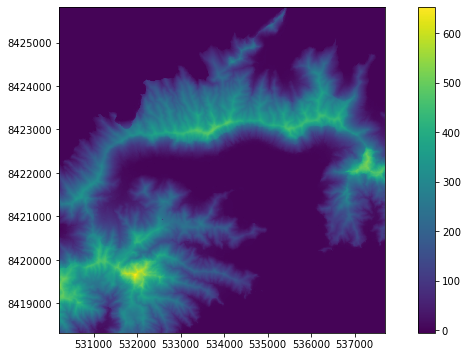

In [79]:
#Set model top to DEM
# Needed to clip the raster to appropriate dimensions, () https://rasterio.readthedocs.io/en/stable/topics/masking-by-shapefile.html)
Raster_2_Clip = os.path.join("..",  'Data/Raw/GIS/3m_DEM', '3m_dem_cp.tif')
Clipped_raster = os.path.join(workspace, "DEM_10m_clip.asc")

with fiona.open(os.path.join(workspace, 'Model_polyarea.shp'), "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]
    
with rasterio.open(Raster_2_Clip) as src:
    out_image, out_transform = rasterio.mask.mask(src, features,
                                                        crop=True)
out_meta = src.meta.copy()

out_meta.update({"driver": "AAIGrid",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
with rasterio.open(Clipped_raster, "w", **out_meta) as dest:
    dest.write(out_image)
    
# Now disect the clipped .asc into a 
Top_raw = np.loadtxt(Clipped_raster, skiprows=7)   # the 7th row was a no data row for some reason not sure why, if another DEM is used might need to skiprows back to 6

y = np.linspace(0, np.shape(Top_raw)[0]-1, np.shape(Top_raw)[0])   
x = np.linspace(0, np.shape(Top_raw)[1]-1, np.shape(Top_raw)[1])

y2 = np.linspace(0, np.shape(y)[0], nrow)   # this defines the number of cells to resample to on the y direction, first number is the original height of the SWB2 recharge map, second number is going to be new height in # of cells
x2 = np.linspace(0, np.shape(x)[0], ncol)   # this defines the number of cells to resample to on the x direction, first number is the original width of the SWB2 recharge map, second number is going to be new width in # of cells

f = interp2d(x, y, Top_raw, kind='cubic')
top = f(x2, y2)

botm = -500    # this will clearly need to change to accomadate the Tutuila bathymetry
top = np.where(top <= botm, botm+10, top) # force top elevations to always be higher than bottom elevations

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(top, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)

Starting heads will be tricky.  Easiest might be to assign starting heads of 0.01 in ocean, then heads of 10 m less than top elevation in land surface areas, if optimization yields different starting heads then can modify. could also use the ending heads from the regional model. 


overall, I bound needs to be 

### starting heads

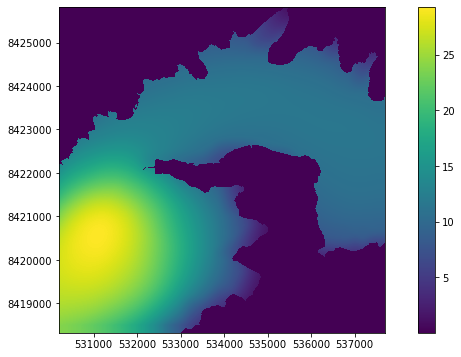

In [80]:
## First import regional heads from the regional model

Raster_2_Clip = os.path.join("..",  'Data/From_regional', 'PyPCGA_model_Heads_Clip.tif')
Clipped_raster = os.path.join(workspace, "PyPCGA_model_Heads_Clip.asc")

with fiona.open(os.path.join(workspace, 'Model_polyarea.shp'), "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]
    
with rasterio.open(Raster_2_Clip) as src:
    out_image, out_transform = rasterio.mask.mask(src, features,
                                                        crop=True)
out_meta = src.meta.copy()

out_meta.update({"driver": "AAIGrid",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
with rasterio.open(Clipped_raster, "w", **out_meta) as dest:
    dest.write(out_image)
    
# Now disect the clipped .asc into a 
Top_raw = np.loadtxt(Clipped_raster, skiprows=7)   # the 7th row was a no data row for some reason not sure why, if another DEM is used might need to skiprows back to 6

y = np.linspace(0, np.shape(Top_raw)[0]-1, np.shape(Top_raw)[0])   
x = np.linspace(0, np.shape(Top_raw)[1]-1, np.shape(Top_raw)[1])

y2 = np.linspace(0, np.shape(y)[0], nrow)   # this defines the number of cells to resample to on the y direction, first number is the original height of the SWB2 recharge map, second number is going to be new height in # of cells
x2 = np.linspace(0, np.shape(x)[0], ncol)   # this defines the number of cells to resample to on the x direction, first number is the original width of the SWB2 recharge map, second number is going to be new width in # of cells

f = interp2d(x, y, Top_raw, kind='cubic')
regional_Heads = f(x2, y2)

#botm = -500    # this will clearly need to change to accomadate the Tutuila bathymetry
#top = np.where(top <= botm, botm+10, top) # force top elevations to always be higher than bottom elevations


# then explicitly say that the ocean area has a specified head, since the regional heads are fuzzy

with fiona.open(os.path.join("..",  'Data/Raw/GIS/ibounds/For_heads', 'Land_Ocean.shp')) as src:   #    read in Tutuila shapefile
    records = [r for r in src] 
geoms = [r['geometry'] for r in records]       # shapefile shape
attr = [r['properties'] for r in records]      # shapefile attributes
geoms = [(g, attr[i]['OceanCell'])for i, g in enumerate(geoms) ]              # select the attribute to map onto the raster grid
# affine: work with the geometry to change from raster to grid reference frame 
trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)
mask = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 

masked_heads = abs(regional_Heads)*mask                        # set ocean cells to a negative number through multoplication with -1
Ocean_starting_head = 0.01   # in meters 
start_heads = np.where(masked_heads < 0, Ocean_starting_head, masked_heads) # Set ocean cells (defined as any negative values in the array) to Ocean_starting_head value

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(start_heads, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)

### make new ibound and specified head 
- Negative ibound (-1) is constant head
- Ibound of (0) is inactive
- Any positive Ibound (1) is variable head (active) 

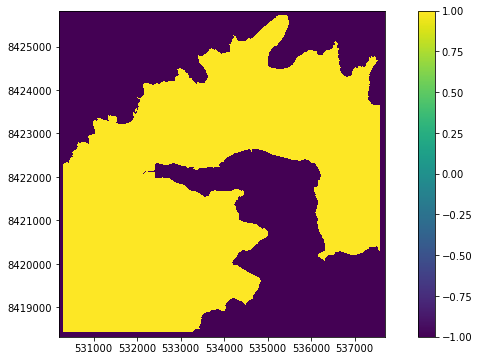

In [81]:
#### Use a Tutuila polygon to define the model active area as the island and the ghb cells as the offshore cells

with fiona.open(os.path.join("..",  'Data/Raw/GIS/ibounds', 'ibound_specHd_w_100m_buff.shp')) as src:   #    read in Tutuila shapefile
    records = [r for r in src] 
geoms = [r['geometry'] for r in records]       # shapefile shape
attr = [r['properties'] for r in records]      # shapefile attributes
geoms = [(g, attr[i]['ibound'])for i, g in enumerate(geoms) ]              # select the attribute to map onto the raster grid
# affine: work with the geometry to change from raster to grid reference frame 
trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)
ibound = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(ibound, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)

### Observation points

note need to cut out obs that are not within the model domain

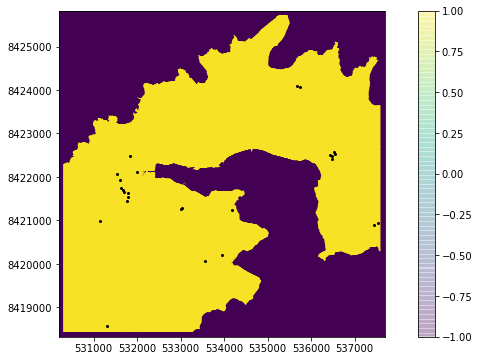

In [82]:
Pdevel_WLs = pd.read_csv(os.path.join("..",  'Data/Raw/Water_levels', 'Predevelop_WLs_MOD_vai183.csv'))

# Cut out observations that are outside of the model square (dont need the y's but could add those too for shoots and giggls
Pdevel_WLs = Pdevel_WLs[Pdevel_WLs['x_utm'] > shp_xmin]
Pdevel_WLs = Pdevel_WLs[Pdevel_WLs['x_utm'] < shp_xmax]

Pdevel_WLs['row_num'] = Pdevel_WLs['x_utm'].apply(lambda x_utm_val: math.ceil((x_utm_val-xll)/delr) )          # this formula calculates the column number based on the x coordinate 
Pdevel_WLs['col_num'] = Pdevel_WLs['y_utm'].apply(lambda y_utm_val: (1+nrow)-math.ceil((y_utm_val-yll)/delc) )   # this formula calculates the row number based on the y coordinate 
Pdevel_WLs['rowcol']  = list(zip(Pdevel_WLs.row_num, Pdevel_WLs.col_num))                                      # just make a tuplel of the row and col

# This takes obs wells that occupy the same cell and averages them! 
Unique_WLs = Pdevel_WLs.groupby('rowcol', as_index=False).mean()                                               # Average the duplicate WLs that fall into a single cell, to get one "observed" water level for that cell 

# make new unique names for each obs point
Unique_WLs["name"] = "Obs_"+Unique_WLs.index.map(str)

nobs = len(Unique_WLs['WL_m_MSL']) 
layervals = [0] * nobs
rowvals = list(Unique_WLs['col_num'].astype(int))
colvals = list(Unique_WLs['row_num'].astype(int))
obsvals = list(Unique_WLs['WL_m_MSL'])
obsnames = list(Unique_WLs["name"])

if Plotnsave_plot: 
    gdf = geopandas.GeoDataFrame(Unique_WLs, geometry=geopandas.points_from_xy(Unique_WLs.x_utm, Unique_WLs.y_utm))
    fig, ax = plt.subplots(figsize = (12,6))
    Grid.plot(ax=ax, facecolor="white", edgecolor="Black", linewidth=.2, alpha = .2)
    qm = sr.plot_array(ibound, ax=ax, alpha = .2)
    ax.set_aspect(1); plt.colorbar(qm)
    gdf.plot(ax=ax, color='black', markersize=4)

### Import Recharge .asc from SWB output into MODFLOW rech array
(note I am not sure what happens when the model area is bigger then the raster....)

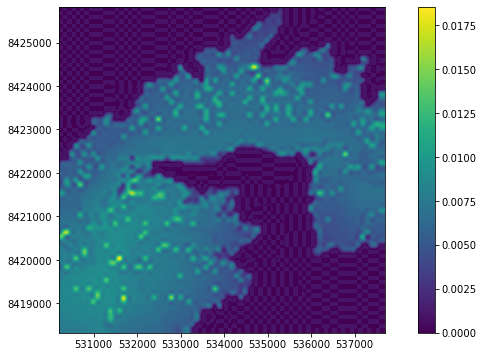

In [83]:
SWB_output_recharge = os.path.join("..",  'Data/Raw/GIS/Recharge','recharge_v1.asc')  

# Needed to clip the raster to appropriate dimensions, () https://rasterio.readthedocs.io/en/stable/topics/masking-by-shapefile.html)   
Raster_2_Clip = os.path.join(SWB_output_recharge)
Clipped_raster = os.path.join(workspace, "raw_net_infiltration_clip.asc")

with fiona.open(os.path.join(workspace, 'Model_polyarea.shp'), "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]
    
with rasterio.open(Raster_2_Clip) as src:
    out_image, out_transform = rasterio.mask.mask(src, features, crop=True)
    
out_meta = src.meta.copy()
out_meta.update({"driver": "AAIGrid",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open(Clipped_raster, "w", **out_meta) as dest:          # create the new clipped .asc file
    dest.write(out_image)
    
# Now disect the clipped .asc into a 
recharge_raw_SWB = np.loadtxt(Clipped_raster, skiprows=6)

y = np.linspace(0, np.shape(recharge_raw_SWB)[0]-1, np.shape(recharge_raw_SWB)[0])   
x = np.linspace(0, np.shape(recharge_raw_SWB)[1]-1, np.shape(recharge_raw_SWB)[1])

y2 = np.linspace(0, np.shape(y)[0], nrow)   # this defines the number of cells to resample to on the y direction, first number is the original height of the SWB2 recharge map, second number is going to be new height in # of cells
x2 = np.linspace(0, np.shape(x)[0], ncol)   # this defines the number of cells to resample to on the x direction, first number is the original width of the SWB2 recharge map, second number is going to be new width in # of cells

f = interp2d(x, y, recharge_raw_SWB, kind='cubic')
recharge_resampled = f(x2, y2)
recharge_converted =  recharge_resampled* (0.0254/365)   # recharge comes out of SWB in inches/year and needs to be converted to m/day

recharge_converted = np.where(recharge_converted < 0, 0.001, recharge_converted)   # Interpolation made some negative values, fix that issue by setting them to a positive value

rch_data = {0: recharge_converted}   # dictionary form to specify that it is only on first layer

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(recharge_converted, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)

### Hydraulic condictivty assigned based on zones as defined by shapefiles in a folder

The values at the top of this cell can be modified to change the conductivity in each zone

In [84]:
# Function to rasterize the HK zones: 
def rastah_zone(shp):
    with fiona.open(shp) as src:   #    read in Tutuila shapefile
            records = [r for r in src]   
    geoms = [r['geometry'] for r in records]       # shapefile shape
    attr = [r['properties'] for r in records]      # shapefile attributes
    geoms = [(g, attr[i]['par_code']) for i, g in enumerate(geoms)]              # select the attribute to map onto the raster grid
    # affine: work with the geometry to change from raster to grid reference frame 
    trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)
    Outrastah = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 
    return Outrastah

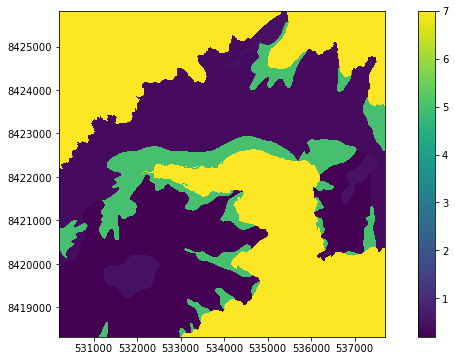

In [85]:
# set the  values this cell is set up for optimization
HK_raster = rastah_zone(os.path.join("..",  'Data/Raw/GIS/Geo_units/v1', 'NPS_simplified_geo_v1.shp'))

calgood = [ 5, 5, 5, 5, 5, 5, 0.2, .2, .2, .4, 0.5]

Alluvium_Aua      = calgood[0]
Alluvium_Fagaalu  = calgood[1]
Alluvium_minor    = calgood[2]
Alluvium_Utulei   = calgood[3]
Alluvium_Vaipito  = calgood[4]
Alluvium_Vatia    = calgood[5]
Dikes             = calgood[6]
Pago_inner_E      = calgood[7]
Pago_inner_W      = calgood[8]
Pago_outer        = calgood[9]
Trachyte          = calgood[10]


map_dic = {-12:Alluvium_Aua, 
           -14:Alluvium_Fagaalu, 
           -15:Alluvium_minor,
           -13:Alluvium_Utulei,
           -11:Alluvium_Vaipito,
           -10:Alluvium_Vatia,
           -50:Dikes,
           -30:Pago_inner_E,
           -40:Pago_inner_W,
           -20:Pago_outer,
           -60:Trachyte}

for i in map_dic:
    HK_raster = np.where(HK_raster== i, map_dic[i], HK_raster)
    
HK_raster = np.where(HK_raster== 0, 7, HK_raster)   # this is for the areas not covered by HK zones, Should not actually maatter at all!

#HK_raster = np.where(HK_raster== -90, 1, HK_raster) # this is for the areas that get messed up somehow
#HK_raster = np.where(HK_raster== -70, 1, HK_raster) # this is for the areas that get messed up somehow

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(HK_raster, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)

'''Define the layers to be confined and define the horizontal and vertical 
hydraulic conductivity of the aquifer for the LPF package.'''

# lpf data
laytyp = 0
vka = 10


In [86]:
modelname = 'modelface'

ml = flopy.modflow.Modflow(modelname, version='mf2005', exe_name=exe_name, model_ws=workspace, verbose=False)

discret = flopy.modflow.ModflowDis(ml, nlay=nlay, nrow=nrow, ncol=ncol, laycbd=0,
                                   delr=delr, delc=delc, top=top, botm=botm,
                                   nper=nper, perlen=perlen, nstp=nstp)
bas = flopy.modflow.ModflowBas(ml, ibound=ibound, strt=start_heads)
lpf = flopy.modflow.ModflowLpf(ml, laytyp=laytyp, hk=HK_raster, vka=vka)
#### ghb = flopy.modflow.ModflowGhb(ml, stress_period_data=ghb_data)
rch = flopy.modflow.ModflowRch(ml, rech=rch_data)

oc = flopy.modflow.ModflowOc(ml, stress_period_data=spd)
pcg = flopy.modflow.ModflowPcg(ml, hclose=1.0e-6, rclose=3.0e-3, mxiter=100, iter1=50)


# water level observations
obs_data= []
for i in range(0,nobs):
    obs = flopy.modflow.HeadObservation(ml, obsname=obsnames[i], layer=layervals[i], row=rowvals[i], column=colvals[i], time_series_data=[[0,obsvals[i]]])
    obs_data.append(obs)
hob = flopy.modflow.ModflowHob(ml, iuhobsv = 7, hobdry=-999, obs_data = obs_data)

# Run model 

if needed: #### Model checker
https://notebook.community/brclark-usgs/flopy/examples/Notebooks/flopy3_ModelCheckerExample
- ml.check()

In [87]:
ml.write_input()
ml.run_model(silent=False)

FloPy is using the following  executable to run the model: .\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: modelface.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2021/09/06  8:45:44

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2021/09/06  8:46:02
 Elapsed run time: 18.021 Seconds

  Normal termination of simulation


(True, [])

## Post process, map and extract results to heads raster file

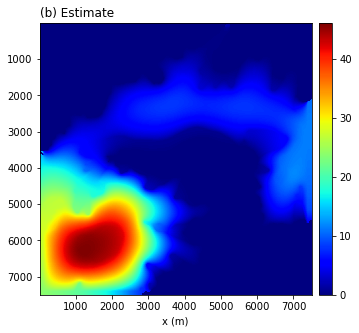

wrote Flo_py_wrkspace/heads.asc


In [88]:
# develop geometry to plot heads as colormap
N = np.array([ncol, nrow, nlay])
dx = np.array([delc, delr, abs(botm)])
Lx = delc*ncol
Ly = delr*nrow
x = np.linspace(0. + dx[0] / 2., Lx - dx[0] / 2., N[0])
y = np.linspace(0. + dx[1] / 2., Ly - dx[1] / 2., N[1])
XX, YY = np.meshgrid(x, y)

# Extract heads data
hds = bf.HeadFile(os.path.join(".", "Flo_py_wrkspace", '{}.hds'.format(modelname)))
times = hds.get_times() # simulation time, steady state
head = hds.get_data(totim=times[-1])
minv = 0
maxv = head.max()

# Plot em
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
im1 = axes.pcolormesh(XX, YY, head[0], vmin=minv, vmax=maxv, cmap=plt.get_cmap('jet'))
axes.set_title('(b) Estimate', loc='left')
axes.set_xlabel('x (m)')
axes.set_aspect('equal')
axes.axis([XX.min(), XX.max(), YY.max(), YY.min()])
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(axes)
cbar_ax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im1, cax=cbar_ax)
plt.show()

# Write the heads layer(s) to a raster file
# export head rasters 
output_raster = os.path.join('Flo_py_wrkspace/heads.asc')   # if there are multiple layers exports based on each layer
grid = ml.modelgrid
flopy.export.utils.export_array(grid, output_raster, head[0])

# Project the output .asc into WGS84 space with manual  ASC header modification 
new_first = ('ncols {}\n'                        # these are the parameters for the .asc file
             'nrows {}\n'
             'xllcorner {}\n'
             'yllcorner {}\n'
             'cellsize {}\n'
             'NODATA_value -999.0'.format(ncol,nrow, xll, yll, np.mean([delc, delr]) ))

with open(os.path.join('.', output_raster), 'r') as fin:   # open file 
    data = fin.read().splitlines(True)
with open(os.path.join('.', output_raster), 'w') as fout:     # delete first line
    fout.writelines(data[6:])
    
with open(os.path.join('.', output_raster), 'r+') as file:                # add in new first line and save file  
    file_data = file.read()
    file. seek(0, 0)
    file. write(new_first + '\n' + file_data)

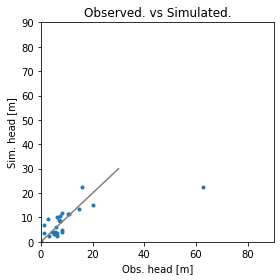

Mean Error: -1.12
Mean Absolute Error: 4.05
RMS Error: 8.50


In [89]:
# plot observations 
observations = np.loadtxt(os.path.join(workspace, '{}.hob.out'.format(modelname)), skiprows=1, usecols=[0,1])      # this block extracts observation data at each well field and determines what the maximum residual at any of the given points is
comp_obs = np.ravel(np.split(observations, 2, 1)[0]) # the computed hed values at the obspts
obs_obs = np.ravel(np.split(observations, 2, 1)[1]) # the observed hed values at the obspts

# note positive residuals means model is calculating too high negative is model calculates too low 
residuals = []
for idx, i in enumerate(observations):   
    r = observations[idx][0]-observations[idx][1]
    residuals.append(r)

Howd_we_do = pd.DataFrame({"Obs_hed_m":obs_obs,"Comp_hed_m":comp_obs,"Residual_m":residuals})

fig = plt.figure(figsize=(4,4))
plt.title('Observed. vs Simulated.')
plt.plot(Howd_we_do["Obs_hed_m"], Howd_we_do["Comp_hed_m"], '.')
#plt.axis('equal')
#plt.axis('square')
plt.xlabel("Obs. head [m]")
plt.ylabel('Sim. head [m]')
plt.ylim(0,90)
plt.xlim(0,90)

plt.plot([0,20,30],[0,20,30], color= "grey")
plt.tight_layout()
plt.savefig(os.path.join(figurespace, "calibration_result.pdf"))

plt.show()

me = np.mean(Howd_we_do.Residual_m)
mea = np.mean(np.abs(Howd_we_do.Residual_m))
rmse = np.sqrt(np.mean(Howd_we_do.Residual_m**2))
print ('Mean Error: {:.2f}\nMean Absolute Error: {:.2f}\nRMS Error: {:.2f}'.format(me, mea, rmse))

In [38]:
def calibrateo(params):
    
    Alluvium_Aua, Alluvium_Fagaalu, Alluvium_minor, Alluvium_Utulei, Alluvium_Vaipito, Alluvium_Vatia, Dikes, Pago_inner_E, Pago_inner_W, Pago_outer, Trachyte= params   
    
    # set the  values this cell is set up for optimization
    HK_raster = rastah_zone(os.path.join("..",  'Data/Raw/GIS/Geo_units/v1', 'NPS_simplified_geo_v1.shp'))

    map_dic = {-12:Alluvium_Aua, 
               -14:Alluvium_Fagaalu, 
               -15:Alluvium_minor,
               -13:Alluvium_Utulei,
               -11:Alluvium_Vaipito,
               -10:Alluvium_Vatia,
               -50:Dikes,
               -30:Pago_inner_E,
               -40:Pago_inner_W,
               -20:Pago_outer,
               -60:Trachyte}

    for i in map_dic:
        HK_raster = np.where(HK_raster== i, map_dic[i], HK_raster)

    HK_raster = np.where(HK_raster== 0, 7, HK_raster)   # this is for the areas not covered by HK zones, Should not actually maatter at all!
    
    
    
    ############    Now generate the run the new model         
    modelname = 'model_pago_OPT'  
        
    ml = flopy.modflow.Modflow(modelname, version='mf2005', exe_name=exe_name, model_ws=workspace, verbose=False)
    
    discret = flopy.modflow.ModflowDis(ml, nlay=nlay, nrow=nrow, ncol=ncol, laycbd=0,
                                       delr=delr, delc=delc, top=top, botm=botm,
                                       nper=nper, perlen=perlen, nstp=nstp)
    
    bas = flopy.modflow.ModflowBas(ml, ibound=ibound, strt=start_heads)
    lpf = flopy.modflow.ModflowLpf(ml, laytyp=laytyp, hk=HK_raster, vka=vka)
    rch = flopy.modflow.ModflowRch(ml, rech=rch_data)
    oc = flopy.modflow.ModflowOc(ml, stress_period_data=spd)
    pcg = flopy.modflow.ModflowPcg(ml, hclose=1.0e-6, rclose=3.0e-3, mxiter=100, iter1=50)


    # water level observations
    obs_data= []
    for i in range(0,nobs):
        obs = flopy.modflow.HeadObservation(ml, obsname=obsnames[i], layer=layervals[i], row=rowvals[i], column=colvals[i], time_series_data=[[0,obsvals[i]]])
        obs_data.append(obs)
    hob = flopy.modflow.ModflowHob(ml, iuhobsv = 7, hobdry=-999, obs_data = obs_data)        
    
    
    # Run da model 
    ml.write_input()
    ml.run_model(silent=True)


    # post process observations 
    observations = np.loadtxt(os.path.join(workspace, '{}.hob.out'.format(modelname)), skiprows=1, usecols=[0,1])      # this block extracts observation data at each well field and determines what the maximum residual at any of the given points is
    comp_obs = np.ravel(np.split(observations, 2, 1)[0]) # the computed hed values at the obspts
    obs_obs = np.ravel(np.split(observations, 2, 1)[1]) # the observed hed values at the obspts

    # note positive residuals means model is calculating too high negative is model calculates too low 
    residuals = []
    for idx, i in enumerate(observations):   
        r = observations[idx][0]-observations[idx][1]
        residuals.append(r)

    Howd_we_do = pd.DataFrame({"Obs_hed_m":obs_obs,"Comp_hed_m":comp_obs,"Residual_m":residuals})
    # error metrics
    me = np.mean(Howd_we_do.Residual_m)
    mea = np.mean(np.abs(Howd_we_do.Residual_m))
    rmse = np.sqrt(np.mean(Howd_we_do.Residual_m**2))
    
#############  Plot the OBS plot if want This can be moved down to utilities when not in use
    fig = plt.figure(figsize=(4,4))
    plt.title('Observed. vs Simulated.')
    plt.plot(Howd_we_do["Obs_hed_m"], Howd_we_do["Comp_hed_m"], '.')
    #plt.axis('equal')
    #plt.axis('square')
    plt.xlabel("Obs. head [m]")
    plt.ylabel('Sim. head [m]')
    plt.ylim(0,90)
    plt.xlim(0,90)
    plt.plot([0,20,30],[0,20,30], color= "grey")
    plt.tight_layout()
    plt.savefig("cal.pdf")
    plt.show()
############    

    print("Error is - {}".format(rmse))
    print("Params are - {}".format(params))
    return rmse

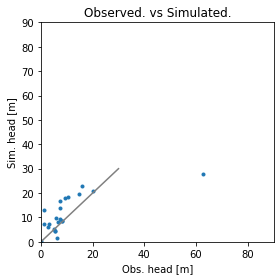

Error is - 9.038330956766842
Params are - [4.6, 13.0, 0.1, 5.0, 2.6, 0.4, 0.3, 0.1, 0.5, 0.6, 0.3]


9.038330956766842

In [39]:
# Run once 
params = [4.6, 13.0, 0.1, 5.0, 2.6, 0.4, 0.3, 0.1, 0.5, 0.6, 0.3]
calibrateo(params)

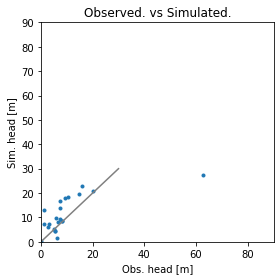

Error is - 9.09079402594897
Params are - [4.6, 13.0, 0.1, 5.0, 2.6, 0.4, 0.3, 0.1, 0.5, 0.6, 0.3]


9.09079402594897

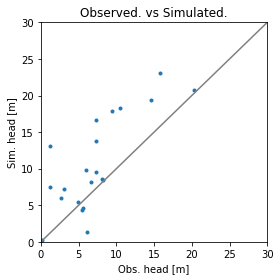

Error is - 9.09079402594897
Params are - [ 4.6 13.   0.1  5.   2.6  0.4  0.3  0.1  0.5  0.6  0.3]


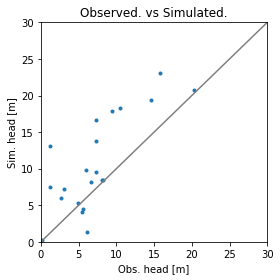

Error is - 9.091978071757747
Params are - [ 4.83 13.    0.1   5.    2.6   0.4   0.3   0.1   0.5   0.6   0.3 ]


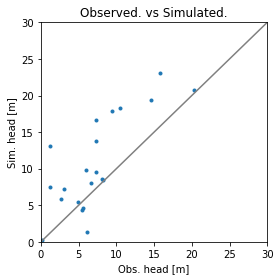

Error is - 9.089582125698309
Params are - [ 4.6  13.65  0.1   5.    2.6   0.4   0.3   0.1   0.5   0.6   0.3 ]


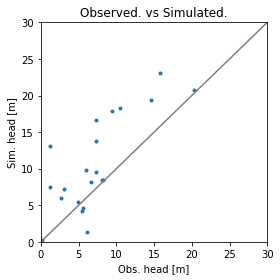

Error is - 9.092122063857454
Params are - [ 4.6   13.     0.105  5.     2.6    0.4    0.3    0.1    0.5    0.6
  0.3  ]


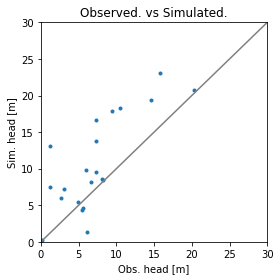

Error is - 9.09077281080634
Params are - [ 4.6  13.    0.1   5.25  2.6   0.4   0.3   0.1   0.5   0.6   0.3 ]


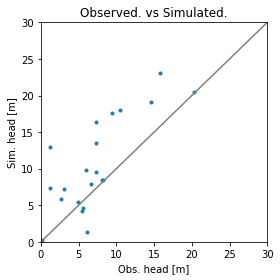

Error is - 9.09558252941067
Params are - [ 4.6  13.    0.1   5.    2.73  0.4   0.3   0.1   0.5   0.6   0.3 ]


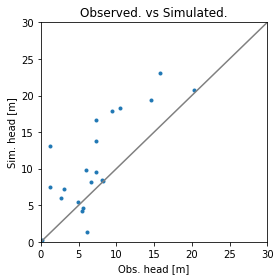

Error is - 9.090607803572416
Params are - [ 4.6  13.    0.1   5.    2.6   0.42  0.3   0.1   0.5   0.6   0.3 ]


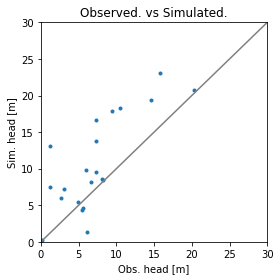

Error is - 9.092908556225474
Params are - [ 4.6   13.     0.1    5.     2.6    0.4    0.315  0.1    0.5    0.6
  0.3  ]


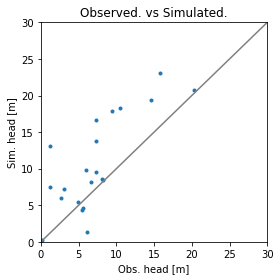

Error is - 9.090473862984355
Params are - [ 4.6   13.     0.1    5.     2.6    0.4    0.3    0.105  0.5    0.6
  0.3  ]


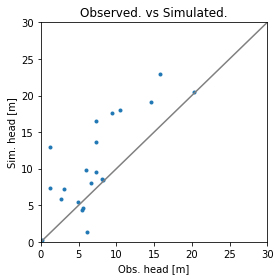

Error is - 9.087966336459688
Params are - [ 4.6   13.     0.1    5.     2.6    0.4    0.3    0.1    0.525  0.6
  0.3  ]


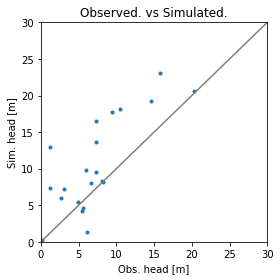

Error is - 9.082420160552509
Params are - [ 4.6  13.    0.1   5.    2.6   0.4   0.3   0.1   0.5   0.63  0.3 ]


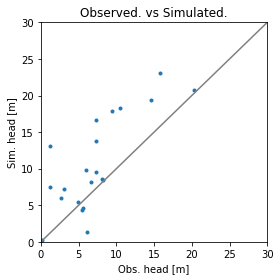

Error is - 9.091986279513982
Params are - [ 4.6   13.     0.1    5.     2.6    0.4    0.3    0.1    0.5    0.6
  0.315]


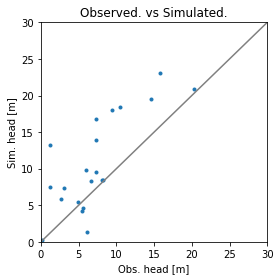

Error is - 9.086752459253974
Params are - [ 4.64181818 13.11818182  0.10090909  5.04545455  2.47        0.40363636
  0.30272727  0.10090909  0.50454545  0.60545455  0.30272727]


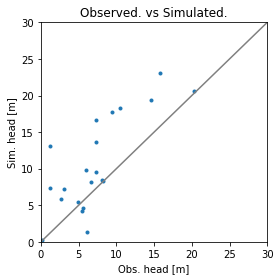

Error is - 9.085732337955875
Params are - [ 4.64942149 13.13966942  0.10107438  5.05371901  2.57636364  0.40429752
  0.28549587  0.10107438  0.5053719   0.60644628  0.30322314]


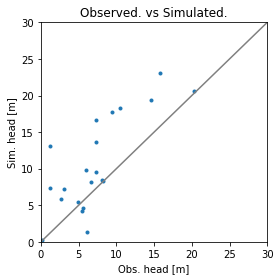

Error is - 9.085280910922512
Params are - [ 4.65840721 13.16506386  0.09536063  5.0634861   2.57206612  0.40507889
  0.29785875  0.10126972  0.50634861  0.60761833  0.30380917]


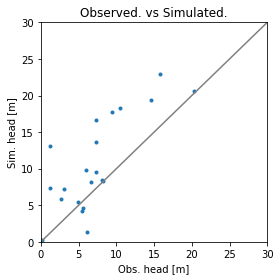

Error is - 9.084222682607173
Params are - [ 4.66902671 13.19507547  0.09951711  5.07502903  2.56698723  0.40600232
  0.29746944  0.10150058  0.5075029   0.60900348  0.28677447]


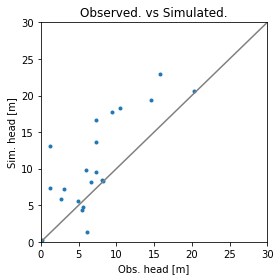

Error is - 9.08317275821187
Params are - [ 4.40975883 13.23054374  0.09942931  5.08867067  2.56098491  0.40709365
  0.29700933  0.10177341  0.50886707  0.61064048  0.29936983]


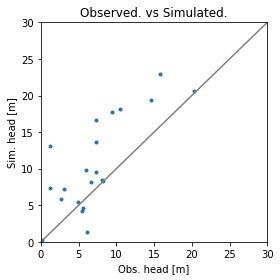

Error is - 9.082760076077545
Params are - [ 4.60516953 13.27246078  0.09932555  5.10479261  2.55389125  0.40838341
  0.29646557  0.10209585  0.51047926  0.61257511  0.29925525]


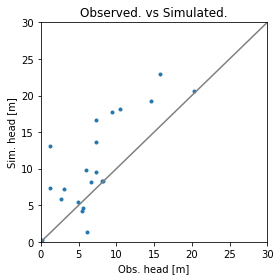

Error is - 9.081373527375634
Params are - [ 4.60610945 13.32199911  0.09920292  4.82839127  2.54550784  0.40990766
  0.29582295  0.10247692  0.51238458  0.6148615   0.29911984]


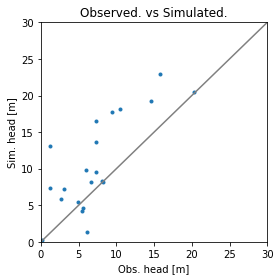

Error is - 9.076905405868438
Params are - [ 4.60916417 13.48299866  0.09880438  4.6175869   2.51826176  0.4148615
  0.29373443  0.10371537  0.51857687  0.62229225  0.29867976]


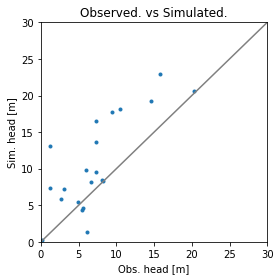

Error is - 9.079011864128807
Params are - [ 4.60777566 13.40981705  0.09898554  5.00886161  2.53064635  0.38897339
  0.29468376  0.10315244  0.51576219  0.61891463  0.2988798 ]


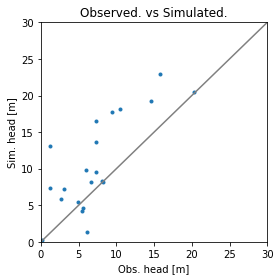

Error is - 9.077238804673152
Params are - [ 4.60918941 13.48432924  0.09880109  5.01047281  2.51803659  0.40696855
  0.29371717  0.09781652  0.51862805  0.62235366  0.29867612]


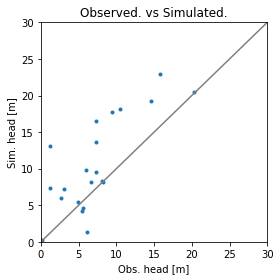

Error is - 9.075968015029964
Params are - [ 4.61086022 12.80420728  0.09858311  5.01237696  2.50313415  0.40823556
  0.29257483  0.10241952  0.52201497  0.62641796  0.29843542]


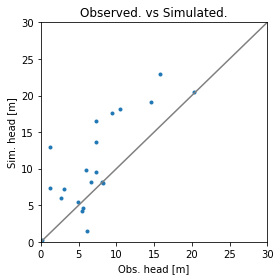

Error is - 9.069719454752594
Params are - [ 4.61629033 12.38131092  0.09787466  5.01856544  2.45470123  0.41235335
  0.28886225  0.10362928  0.53302245  0.63962694  0.29765313]


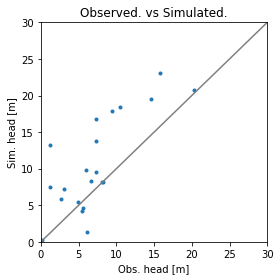

Error is - 9.074923161836526
Params are - [ 4.61382209 13.34171836  0.09819668  5.0157525   2.47671619  0.41048163
  0.29054979  0.10307939  0.49847359  0.63362286  0.29800872]


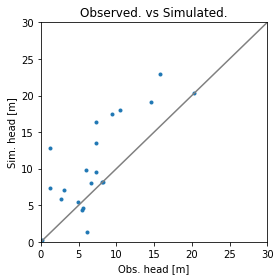

Error is - 9.076606350808994
Params are - [ 4.56691372 13.26417955  0.09679442  4.96489758  2.60793732  0.40808986
  0.28560843  0.1025649   0.51782416  0.63328982  0.29442352]


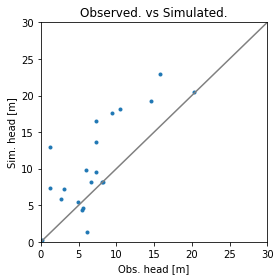

Error is - 9.072569902398072
Params are - [ 4.544309   13.26533015  0.09585096  4.94048376  2.50731435  0.40811821
  0.3028603   0.10267062  0.51926176  0.63717873  0.29232773]


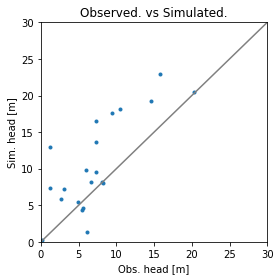

Error is - 9.070729178177492
Params are - [ 4.51457814 13.25816594  0.10165386  4.90835261  2.49983883  0.40788945
  0.29140679  0.10272998  0.5206329   0.6413813   0.28965417]


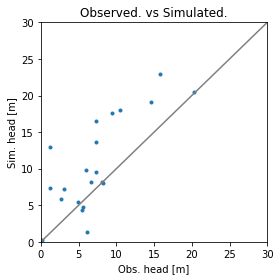

Error is - 9.06942357021118
Params are - [ 4.47587709 13.23962533  0.09788588  4.86650488  2.49270891  0.40730913
  0.2906938   0.10272265  0.52186588  0.64588302  0.30721244]


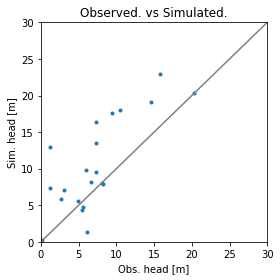

Error is - 9.06264501384005
Params are - [ 4.37930228 13.26190025  0.09707027  4.7622428   2.45556976  0.40796254
  0.28730599  0.10333369  0.52904737  0.66432279  0.31743143]


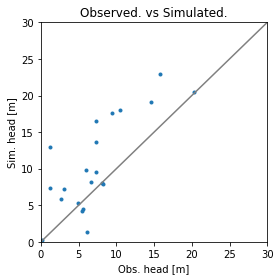

Error is - 9.067006014265116
Params are - [ 4.72960741 13.20985824  0.09754476  4.79351272  2.47954485  0.40637578
  0.28938966  0.1027335   0.52417086  0.65400644  0.29790101]


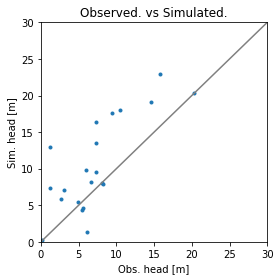

Error is - 9.06430845239966
Params are - [ 4.55682178 13.15655892  0.09732475  4.72079443  2.47312097  0.404721
  0.28864689  0.102527    0.52504805  0.65960478  0.29776937]


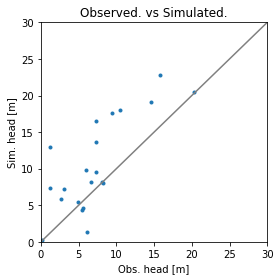

Error is - 9.061206980149626
Params are - [ 4.55414072 13.45748496  0.09616389  4.77482239  2.40394331  0.41396277
  0.28304826  0.10508231  0.5400815   0.64756258  0.29661905]


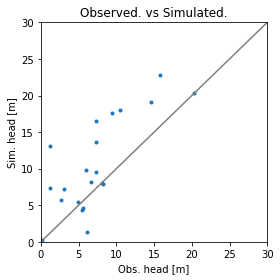

Error is - 9.051171165004611
Params are - [ 4.53121109 13.68622744  0.09424583  4.66223359  2.30591496  0.42094416
  0.27457239  0.10762346  0.56012225  0.65634387  0.29492857]


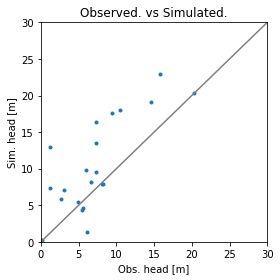

Error is - 9.059756170491413
Params are - [ 4.53244424 13.09792435  0.09631658  4.70293751  2.43243671  0.43080225
  0.28470789  0.10274278  0.53238477  0.66545326  0.29702084]


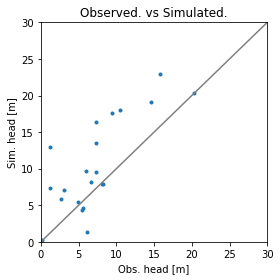

Error is - 9.058150303962021
Params are - [ 4.51707681 12.95315672  0.0960493   4.64541079  2.42948285  0.41714049
  0.28403643  0.10897439  0.53202014  0.66985053  0.29692356]


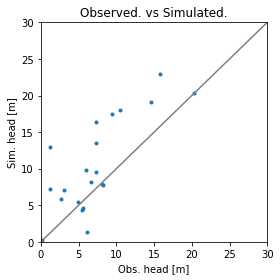

Error is - 9.055095519169077
Params are - [ 4.5003589  12.8581524   0.09554509  5.0433556   2.41311606  0.4096619
  0.2822559   0.10403172  0.53451555  0.6785589   0.29660061]


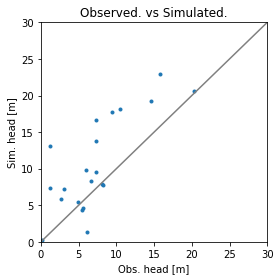

Error is - 9.052254763069175
Params are - [ 4.53050848 13.0031484   0.09732789  4.71031001  2.28801845  0.41671937
  0.28977235  0.10544888  0.53830306  0.67579207  0.30125268]


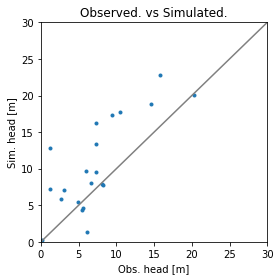

Error is - 9.05378298062554
Params are - [ 4.46845217 12.86405141  0.09576768  4.6039201   2.3849309   0.41546174
  0.28468964  0.10536521  0.56489535  0.68312616  0.2982573 ]


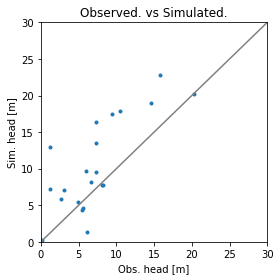

Error is - 9.047992280519532
Params are - [ 4.52417312 12.86747985  0.09809825  4.61799544  2.3320812   0.41916034
  0.26907537  0.10626391  0.55240419  0.68792437  0.3050164 ]


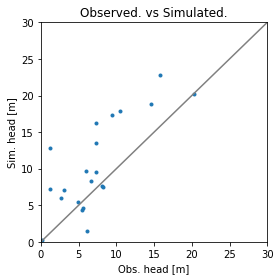

Error is - 9.036195138525347
Params are - [ 4.51410517 12.6685547   0.0992219   4.45675127  2.24446463  0.4246814
  0.25218291  0.10806056  0.56897541  0.71329719  0.31136073]


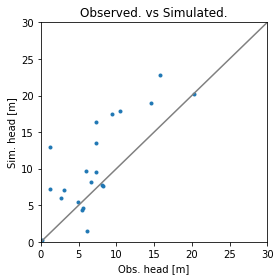

Error is - 9.04357308306576
Params are - [ 4.55381798 12.76744201  0.09185318  4.56801726  2.29312506  0.42244218
  0.27339727  0.10717374  0.5598226   0.69679742  0.3116366 ]


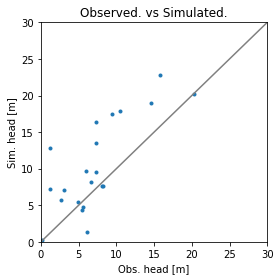

Error is - 9.040074197614539
Params are - [ 4.44074718 13.71450269  0.09453756  4.37588657  2.30888517  0.41981262
  0.27312999  0.10691888  0.55230581  0.70894641  0.30618009]


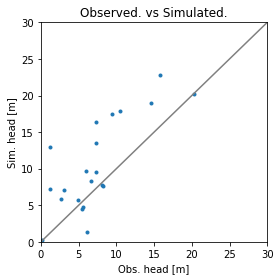

Error is - 9.037789318483831
Params are - [ 4.27491006 12.9777089   0.09432069  4.52500727  2.25301252  0.42823325
  0.26964628  0.10857564  0.56627284  0.70455599  0.30743749]


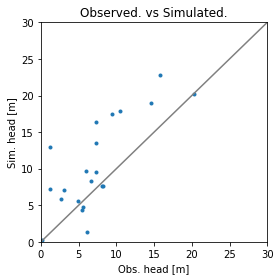

Error is - 9.03555280184787
Params are - [ 4.39643901 12.99849004  0.09399452  4.56212789  2.21941668  0.43416298
  0.26693439  0.1098819   0.57289107  0.7071306   0.30932698]


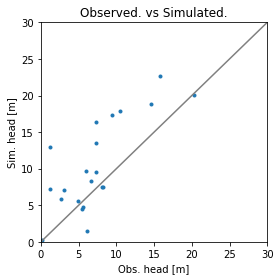

Error is - 9.021819032113475
Params are - [ 4.31624763 12.9194556   0.09232941  4.48279462  2.09256454  0.44888397
  0.25607814  0.11355935  0.59681258  0.73089351  0.31510579]


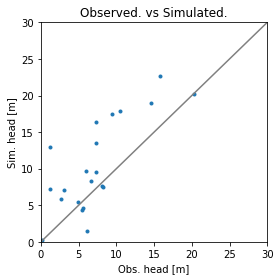

Error is - 9.029345060666708
Params are - [ 4.56249403 12.83088604  0.09338702  4.46987076  2.17096694  0.4383617
  0.2625975   0.11093443  0.5812127   0.71451636  0.28924207]


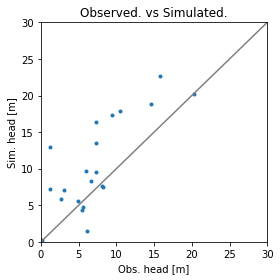

Error is - 9.026993940371783
Params are - [ 4.41481567 12.94630953  0.09360806  4.48680028  2.14656003  0.41689644
  0.26117553  0.11301472  0.5867531   0.72230645  0.30823834]


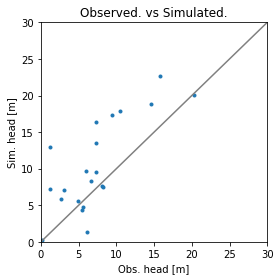

Error is - 9.023298978750992
Params are - [ 4.41159016 13.08983221  0.09343148  4.51548872  2.09807338  0.43051383
  0.25769046  0.10751772  0.59706917  0.72744662  0.31039286]


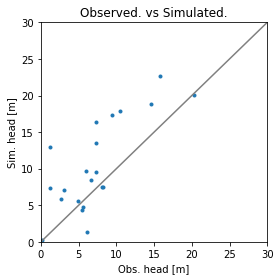

Error is - 9.020972324724266
Params are - [ 4.4121683  13.22696014  0.09355141  4.02156812  2.05715969  0.44178367
  0.25500455  0.11309421  0.60594715  0.72762693  0.31322349]


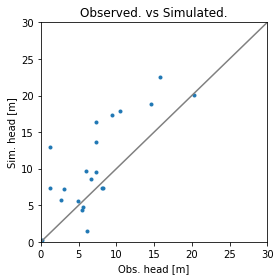

Error is - 9.005585200255306
Params are - [ 4.36807301 13.411364    0.09255457  3.51067439  1.8791815   0.45784455
  0.24137887  0.11762546  0.64166295  0.75216094  0.32153493]


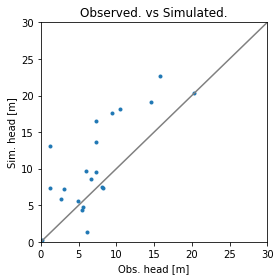

Error is - 9.012560802648903
Params are - [ 4.42582428 13.3205725   0.09274462  4.26223167  1.99339041  0.4436898
  0.24469612  0.11398985  0.5895251   0.73561144  0.31579909]


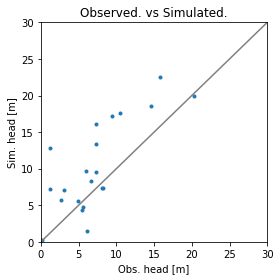

Error is - 9.010400046249625
Params are - [ 4.34473448 13.23918899  0.09035107  4.07437297  2.03673412  0.44733588
  0.23141773  0.11545908  0.62543049  0.75382179  0.31544851]


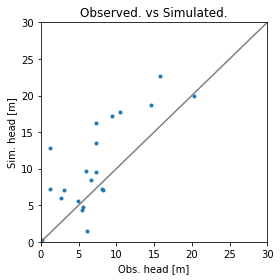

Error is - 9.001550515899915
Params are - [ 4.31012703 12.47483023  0.092725    4.01556565  1.96989564  0.44790958
  0.23877139  0.11470916  0.61548552  0.79099324  0.32550352]


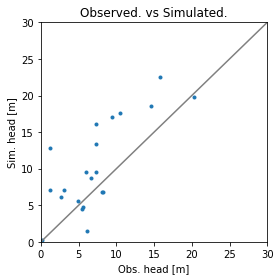

Error is - 8.977568321069274
Params are - [ 4.199585   11.86913162  0.09196459  3.69223167  1.80188598  0.4613923
  0.22087089  0.11825201  0.64316715  0.85831793  0.340791  ]


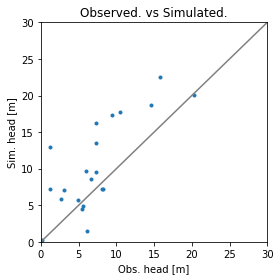

Error is - 8.995879485599371
Params are - [ 4.22311415 13.2302865   0.09513791  3.95054824  1.89336934  0.45349341
  0.23039626  0.11717311  0.63093872  0.77990706  0.31409629]


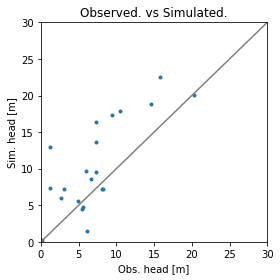

Error is - 8.99262670966846
Params are - [ 4.2966153  12.19518651  0.09256268  4.06534468  1.8020609   0.46224674
  0.22289377  0.11929237  0.65275241  0.78066     0.32099211]


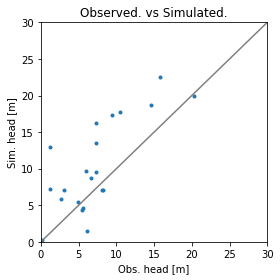

Error is - 8.985691221200003
Params are - [ 4.46639883 12.7897035   0.09245991  3.83264896  1.77594234  0.46001039
  0.21787703  0.11958411  0.65450894  0.79888752  0.32219918]


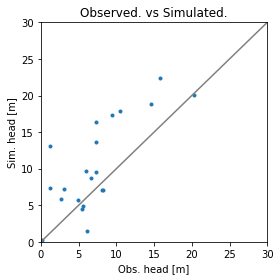

Error is - 8.979942597472718
Params are - [ 4.21852983 13.12088476  0.08632925  3.78743181  1.69930437  0.46998569
  0.22910296  0.12219439  0.66735792  0.8057082   0.32024657]


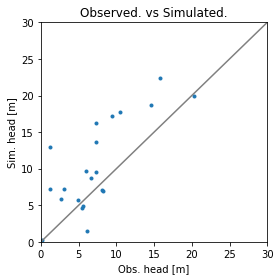

Error is - 8.976326997310299
Params are - [ 4.10760203 13.01128045  0.09088089  3.65023252  1.68704522  0.4620552
  0.21259845  0.12136779  0.6707834   0.82106936  0.34800241]


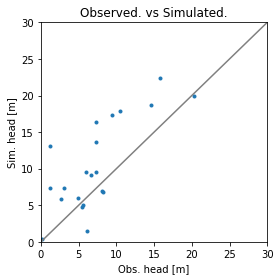

Error is - 8.951756241986708
Params are - [ 3.88015604 13.10147766  0.08962782  3.2404134   1.44508436  0.47390196
  0.18759893  0.12658447  0.71556875  0.87434586  0.37738258]


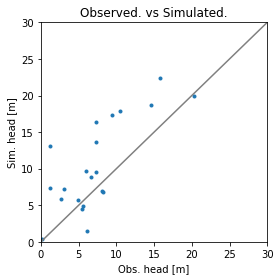

Error is - 8.964551080066641
Params are - [ 4.15806955 12.92406935  0.08993617  3.40668719  1.5839111   0.49388511
  0.20064287  0.12175472  0.68866403  0.8409228   0.34157783]


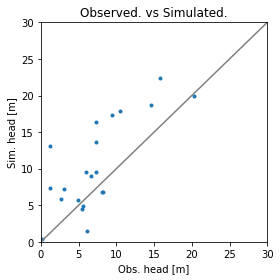

Error is - 8.957033442075746
Params are - [ 4.1152004  12.75040797  0.08947724  3.17639848  1.5389137   0.49178977
  0.19375565  0.12984027  0.69500156  0.85641466  0.3450933 ]


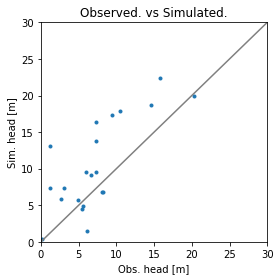

Error is - 8.947149840320234
Params are - [ 4.17398889 12.89004865  0.09006074  2.97156601  1.44375876  0.48122069
  0.1840366   0.12675881  0.7131107   0.8757898   0.34583264]


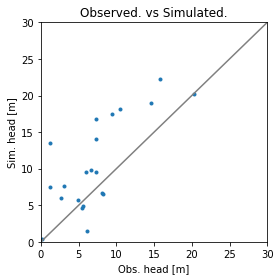

Error is - 8.917564011291347
Params are - [ 4.10285952 12.87534517  0.08892641  2.2159517   1.11935587  0.49738905
  0.14801583  0.13335854  0.77125976  0.94823794  0.36119607]


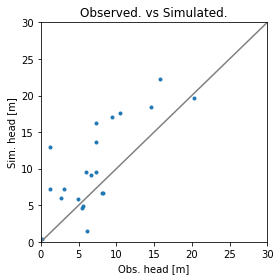

Error is - 8.942892943775284
Params are - [ 4.00569137 12.40798132  0.08895131  2.82007805  1.38401752  0.49617835
  0.17784038  0.12984988  0.75344084  0.90973123  0.35339334]


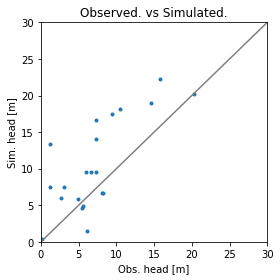

Error is - 8.938046032811883
Params are - [ 4.02513697 12.33823617  0.09109035  2.77988313  1.22199806  0.50141272
  0.18137743  0.13099716  0.74081006  0.91986806  0.36064298]


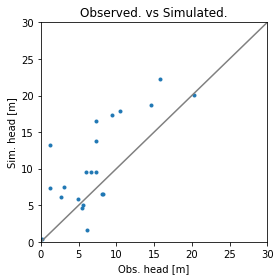

Error is - 8.917677098371497
Params are - [ 3.93944644 11.970947    0.08862064  3.21071058  1.26006278  0.49882554
  0.16050695  0.13126201  0.74260435  0.95202111  0.36166712]


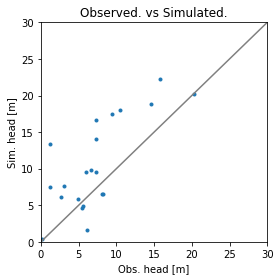

Error is - 8.923651540290848
Params are - [ 4.03282935 11.92305369  0.08485234  2.63632079  1.13072829  0.51141889
  0.15878241  0.13427597  0.77363142  0.95556845  0.377755  ]


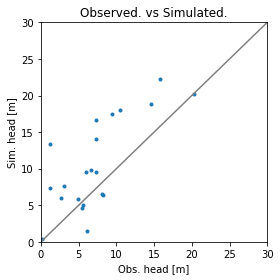

Error is - 8.910875613963437
Params are - [ 3.91136712 12.90867498  0.08602569  2.26170183  1.09997626  0.51160594
  0.15462829  0.134881    0.77379573  0.98661704  0.3811797 ]


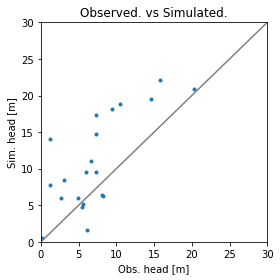

Error is - 8.920359598260301
Params are - [ 3.71874303 13.26541921  0.0827572   1.3598804   0.74893393  0.53628554
  0.12049555  0.14267531  0.83431739  1.08959556  0.4112735 ]


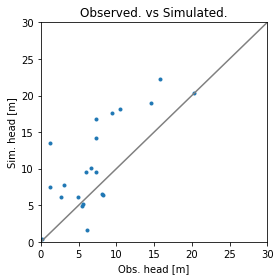

Error is - 8.913285121591707
Params are - [ 3.64066873 12.33578917  0.08495861  2.20877079  1.00319189  0.52322331
  0.14814526  0.13737051  0.79372771  1.00252217  0.39069636]


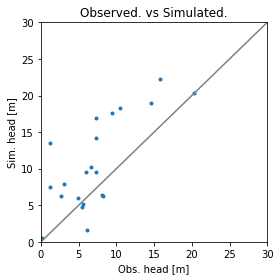

Error is - 8.898757866852913
Params are - [ 3.78347208 11.86186326  0.09084006  1.96695866  0.95326396  0.52292757
  0.12219974  0.13751953  0.80385505  1.03148584  0.40545802]


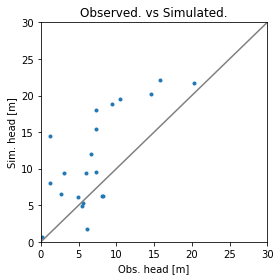

Error is - 8.954084614684435
Params are - [ 3.5659432  11.23235252  0.09309546  1.05672209  0.58024375  0.5493985
  0.06874813  0.1451821   0.87210362  1.14437467  0.44806375]


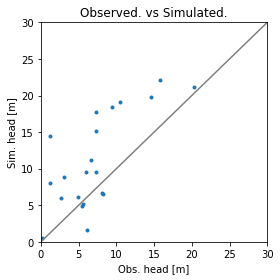

Error is - 8.979610922246119
Params are - [ 3.72676001 13.11229487  0.08500026  1.7484728   0.69638744  0.5427092
  0.11249161  0.14496509  0.85726181  1.01036119  0.39667124]


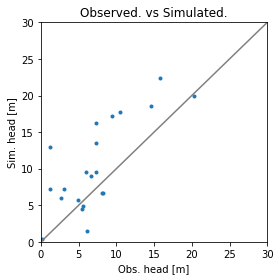

Error is - 8.949617797330719
Params are - [ 4.08137875 12.17992244  0.0902235   3.20629196  1.52551134  0.48172152
  0.19377607  0.12493028  0.69669081  0.89632875  0.35476106]


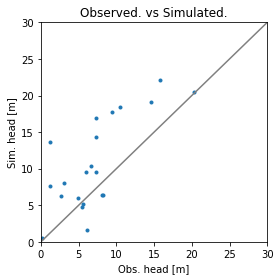

Error is - 8.908037309018836
Params are - [ 3.75433169 11.9220577   0.08708092  1.99758178  0.90374418  0.50800482
  0.13147112  0.14203975  0.81322435  1.03783013  0.39828136]


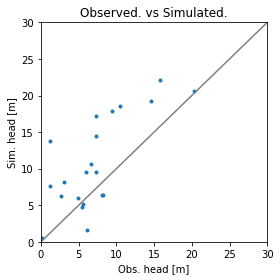

Error is - 8.915803608351277
Params are - [ 3.73158834 11.94510995  0.08710415  2.01354019  0.8332562   0.51304835
  0.12703388  0.13617229  0.82838186  1.0553229   0.40443644]


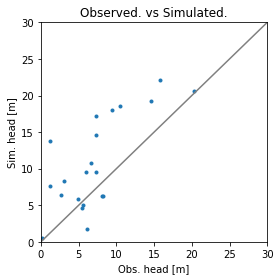

Error is - 8.909244549096666
Params are - [ 3.93962039 11.38379159  0.08649472  1.72645741  0.81584407  0.53805369
  0.12217877  0.14117133  0.82832615  1.07029661  0.37706605]


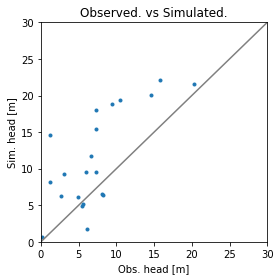

Error is - 8.99954669870408
Params are - [ 3.71262343 12.16059574  0.08522108  1.49151803  0.60638667  0.54047634
  0.10298394  0.14577844  0.87113778  1.07994425  0.40374302]


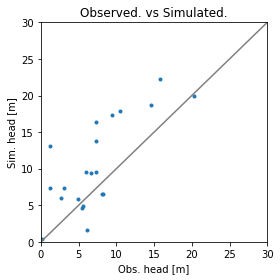

Error is - 8.926846453182291
Params are - [ 3.98918992 12.17509076  0.0889729   2.77759847  1.29573017  0.49641023
  0.17107804  0.13014232  0.74030256  0.94223262  0.36700655]


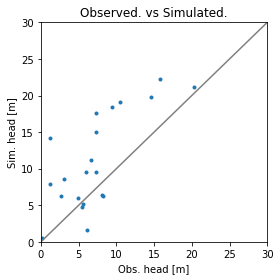

Error is - 8.93682962425755
Params are - [ 3.78531055 11.89019312  0.08649719  1.87000838  0.73182825  0.52606167
  0.11769011  0.14091201  0.81199898  1.07245111  0.40758587]


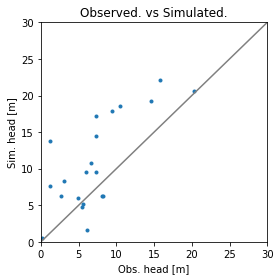

Error is - 8.888345324225916
Params are - [ 3.72226014 11.87847591  0.08352303  1.74477152  0.80472592  0.52530892
  0.10257354  0.14156743  0.83757319  1.09005666  0.4088713 ]


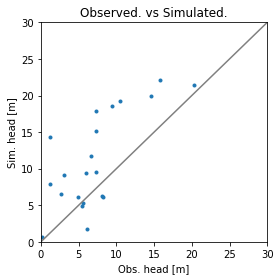

Error is - 8.904489480114222
Params are - [ 3.57082173 11.64859578  0.07973937  1.22721572  0.59608986  0.53725702
  0.0631716   0.14685256  0.88595476  1.17515095  0.43298547]


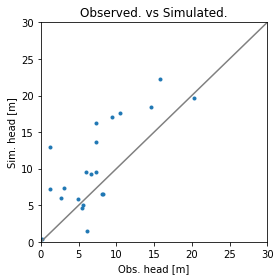

Error is - 8.930325828015125
Params are - [ 3.95062286 12.32438855  0.08757544  2.63187594  1.30814985  0.50052312
  0.1635124   0.13177175  0.77103414  0.94067461  0.36216212]


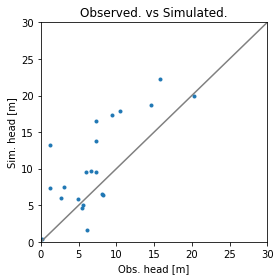

Error is - 8.915011176319807
Params are - [ 3.90929478 12.21583969  0.08730588  2.44140905  1.16406945  0.50690775
  0.15205683  0.13405682  0.78127535  0.97361874  0.37351806]


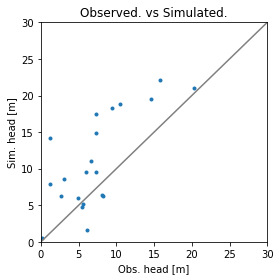

Error is - 8.929355759819684
Params are - [ 3.73221709 12.0468998   0.08479664  1.66316049  0.72030962  0.5320832
  0.10666608  0.14325317  0.85018016  1.07659966  0.40392536]


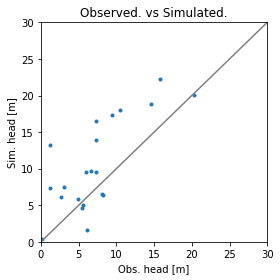

Error is - 8.913738600999645
Params are - [ 3.92494671 12.14304302  0.08792883  2.49898898  1.15187503  0.50532847
  0.15497505  0.13342003  0.76777196  0.97582438  0.37623625]


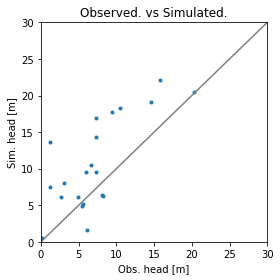

Error is - 8.888775198526416
Params are - [ 3.66896264 12.33893493  0.08947656  1.77946875  0.88915637  0.51596718
  0.11826945  0.13896389  0.81578594  1.06694673  0.39290077]


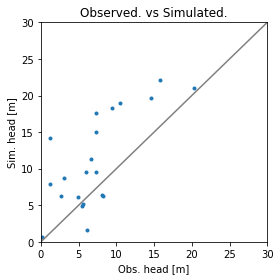

Error is - 8.943502199909666
Params are - [ 3.71316668 12.35794852  0.08586388  0.94485318  0.69238435  0.5316772
  0.10886537  0.1433782   0.86011875  1.09138964  0.4146675 ]


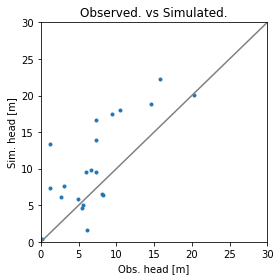

Error is - 8.907212579703346
Params are - [ 3.8828765  12.06769738  0.08793145  2.64424623  1.11814317  0.50703845
  0.14759655  0.13429106  0.77198295  0.98686324  0.37491721]


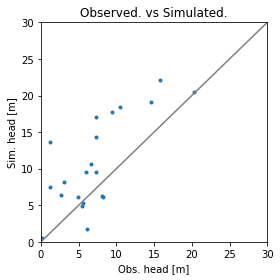

Error is - 8.896187762633122
Params are - [ 3.50975669 11.3067053   0.08537721  2.01748379  0.83287077  0.53486813
  0.12128026  0.14145121  0.83159483  1.1021956   0.4176333 ]


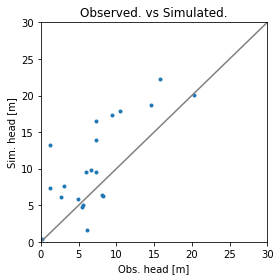

Error is - 8.899366675445032
Params are - [ 3.84069483 12.12086695  0.08688548  2.22061232  1.11890035  0.52317606
  0.14121609  0.13959726  0.7750569   1.00363295  0.37679236]


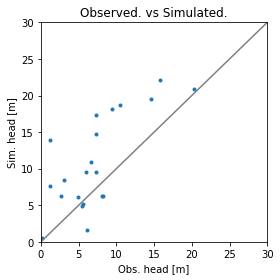

Error is - 8.905532228049736
Params are - [ 3.65051568 11.83286944  0.08660732  1.7525986   0.77987454  0.53227453
  0.1142221   0.14272009  0.82103279  1.09079424  0.40830606]


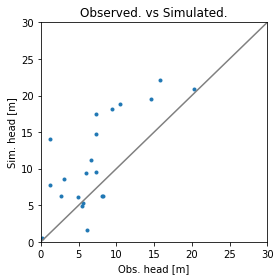

Error is - 8.910771483682762
Params are - [ 3.58496719 11.84927091  0.08574408  1.55931133  0.7244325   0.53875309
  0.10389426  0.1450478   0.84421997  1.1094922   0.41141875]


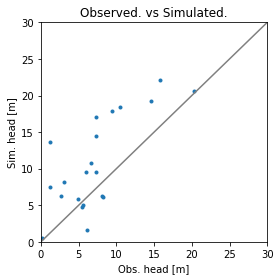

Error is - 8.880208430285116
Params are - [ 3.85911762 11.56806689  0.08885712  1.73144598  0.82243213  0.52368186
  0.10267841  0.14249319  0.82744462  1.10224351  0.40072635]


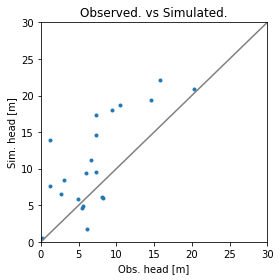

Error is - 8.867101978751768
Params are - [ 3.96834206 11.18420576  0.09080638  1.49278357  0.73205225  0.52391113
  0.07994499  0.14505453  0.84430308  1.15210418  0.40574134]


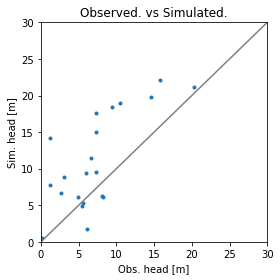

Error is - 8.908050505676766
Params are - [ 3.59877831 10.68164123  0.08865925  1.53871162  0.65875248  0.53753653
  0.0826166   0.14683244  0.86019612  1.14823721  0.41470876]


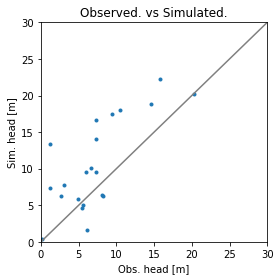

Error is - 8.893044620359172
Params are - [ 3.92768936 11.52874899  0.08947089  2.23735672  1.02235441  0.51016818
  0.12948196  0.13699012  0.79267664  1.0324066   0.38506789]


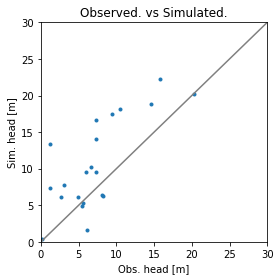

Error is - 8.878280533644737
Params are - [ 3.57086688 12.0205842   0.08926138  2.16310142  0.96849019  0.50579749
  0.11252531  0.14010636  0.80208873  1.06471309  0.42087548]


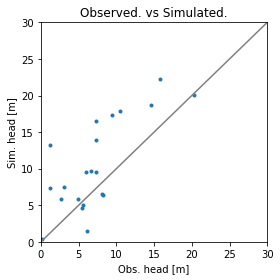

Error is - 8.913619271659512
Params are - [ 3.90663415 12.96617874  0.08720633  2.46437263  1.18189772  0.50054392
  0.15752542  0.13322233  0.75965378  0.97158629  0.38435399]


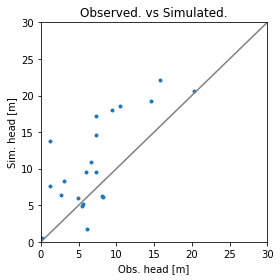

Error is - 8.888816762442573
Params are - [ 3.67574227 11.25277561  0.08829602  1.77012687  0.78953879  0.52828837
  0.10134381  0.14342991  0.83506054  1.10407448  0.40712007]


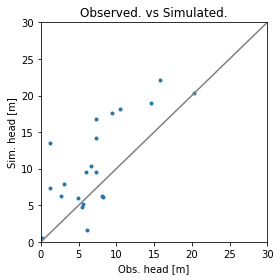

Error is - 8.866604559002528
Params are - [ 3.73679179 11.60407461  0.08900559  1.96414703  0.91614141  0.53376354
  0.10319321  0.13826777  0.81059577  1.0940378   0.40238842]


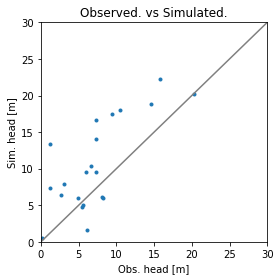

Error is - 8.846900085891118
Params are - [ 3.72802184 11.44508306  0.08996792  1.94742965  0.92234003  0.54664291
  0.08905426  0.13638179  0.80928149  1.12214164  0.40444195]


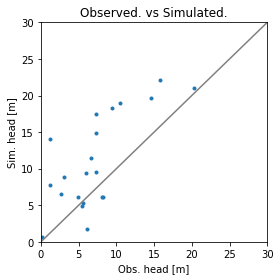

Error is - 8.886678467858166
Params are - [ 3.58009159 11.34523233  0.08852532  1.19078866  0.66614184  0.54193072
  0.07642372  0.1463966   0.85861872  1.16960076  0.43112071]


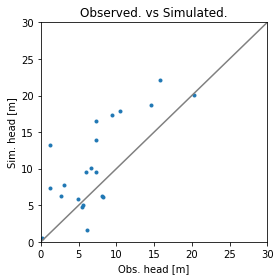

Error is - 8.870158682669826
Params are - [ 3.79964803 11.49139898  0.09019818  1.98028902  0.9837318   0.51845032
  0.10292574  0.13863602  0.81640269  1.07999822  0.40187997]


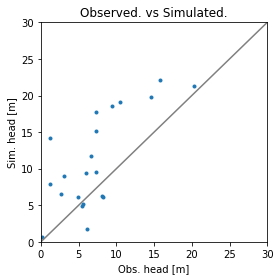

Error is - 8.898978793758877
Params are - [ 3.60200581 11.08895275  0.09052233  1.46858016  0.62012989  0.52668957
  0.06896987  0.14158408  0.86989599  1.18104411  0.43795506]


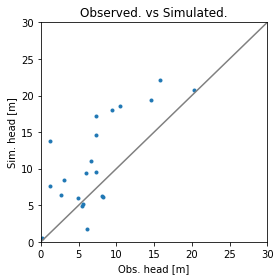

Error is - 8.877984392131793
Params are - [ 3.66167807 11.3469313   0.08961312  1.6565882   0.74482251  0.52581119
  0.08703142  0.14108738  0.84618622  1.13669132  0.42266439]


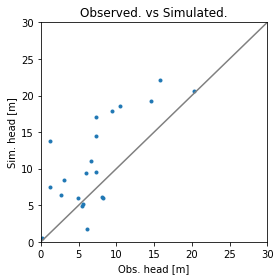

Error is - 8.8541318760097
Params are - [ 3.63708421 11.25433244  0.08634467  1.66580282  0.74786784  0.52746235
  0.08159198  0.14431052  0.84879441  1.17231948  0.41241783]


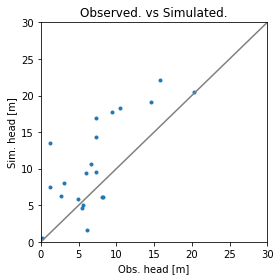

Error is - 8.845081414289288
Params are - [ 3.93395005 11.79996806  0.09198342  1.55133571  0.85280595  0.51417528
  0.07529541  0.14089871  0.82418183  1.11435952  0.39929428]


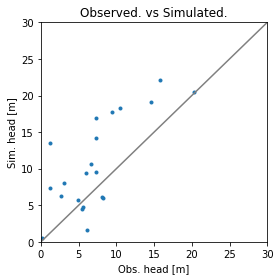

Error is - 8.819603940456075
Params are - [ 4.14604674 12.04659944  0.09528653  1.31826166  0.86277355  0.50382886
  0.05230299  0.14062245  0.82047534  1.12044149  0.39012477]


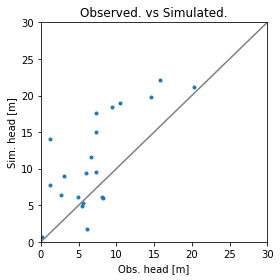

Error is - 8.853786159062265
Params are - [ 3.55571873 11.672079    0.08894713  1.16435458  0.6343076   0.53772263
  0.05306117  0.14602023  0.86815433  1.20015487  0.43277912]


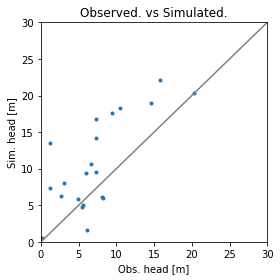

Error is - 8.835167388581539
Params are - [ 3.78584335 12.02428937  0.09024038  1.52144401  0.83889937  0.52131775
  0.07242066  0.1400514   0.83178749  1.14595615  0.41539223]


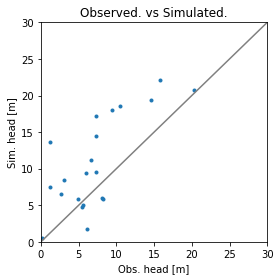

Error is - 8.814756738561483
Params are - [ 3.81387402 10.88092176  0.08919872  1.46518854  0.73014416  0.53461177
  0.04715887  0.14471514  0.85397146  1.19744924  0.43370088]


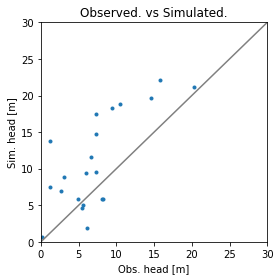

Error is - 8.754891684302338
Params are - [ 3.88632971 10.15191517  0.08905981  1.30804844  0.65063805  0.54393407
  0.01160358  0.14759077  0.87306422  1.26270049  0.45410094]


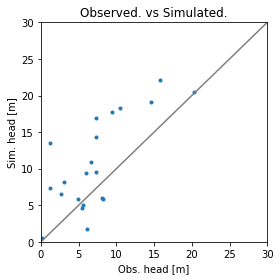

Error is - 8.800111500850226
Params are - [ 3.79040735 11.02746065  0.09615893  1.42048158  0.78655863  0.52865643
  0.04631479  0.14320676  0.83863712  1.20572911  0.42595392]


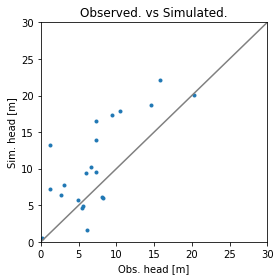

Error is - 8.82812225919612
Params are - [ 3.97081513 11.50292756  0.09254458  2.01622679  0.94703667  0.50962112
  0.06699026  0.13779761  0.81395857  1.13275379  0.4027651 ]


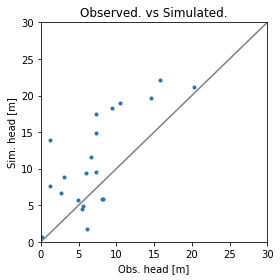

Error is - 8.778563042844658
Params are - [ 4.05275771 10.73345629  0.09240546  1.01720955  0.64078768  0.54644956
  0.02260957  0.14366808  0.87264671  1.2500125   0.40971753]


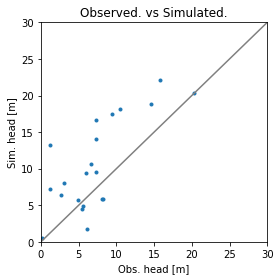

Error is - 8.786653740668365
Params are - [ 4.0330519  11.29556829  0.09256142  1.4074721   0.84553994  0.53018829
  0.03639039  0.14315629  0.83336023  1.19863812  0.40557465]


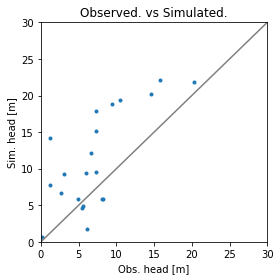

Error is - 8.7476137464478
Params are - [3.93751901e+00 1.11154950e+01 9.24060373e-02 9.79622750e-01
 5.81504853e-01 5.39683332e-01 8.39873928e-03 1.46429510e-01
 8.66226946e-01 1.27690211e+00 4.27030826e-01]


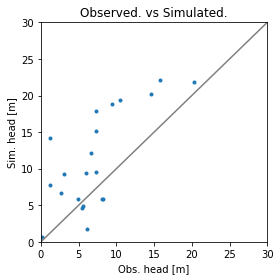

Error is - 8.7476137464478
Params are - [ 4.00645451 10.92754304  0.09350996  0.47928961  0.38039138  0.55029984
 -0.03886476  0.15032625  0.89113908  1.37535405  0.43960625]


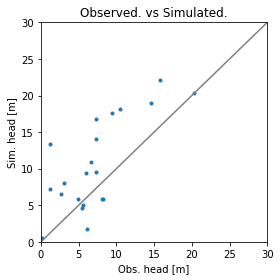

Error is - 8.76245579364847
Params are - [ 3.76322079 11.41019539  0.09208869  1.37382624  0.80581215  0.5370902
  0.01837108  0.14026099  0.84231271  1.22748668  0.42704027]


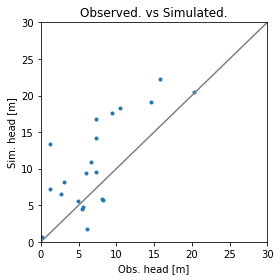

Error is - 8.756848567024246
Params are - [4.11741257e+00 1.13684074e+01 9.75947634e-02 1.14772033e+00
 8.00531894e-01 5.35289494e-01 5.22937531e-03 1.40268733e-01
 8.36642884e-01 1.21730178e+00 4.23022413e-01]


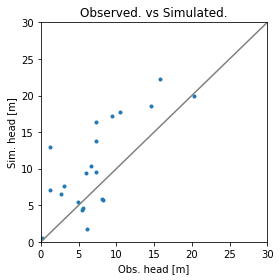

Error is - 8.79089455762944
Params are - [ 4.3009042  10.89544785  0.0965646   1.64614416  0.94431473  0.52458683
  0.0250635   0.1375133   0.81155361  1.19258402  0.40088717]


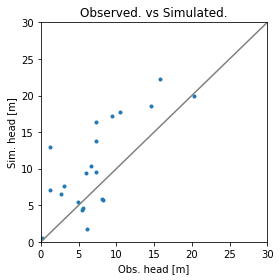

Error is - 8.79089455762944
Params are - [ 4.23276151 11.02251011  0.09674321  0.80828991  0.6602777   0.51165635
 -0.02256427  0.14735747  0.87083957  1.28340495  0.42857801]


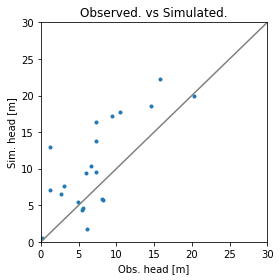

Error is - 8.79089455762944
Params are - [ 4.25619786 10.26116212  0.09765308  1.10461117  0.71124169  0.53522489
 -0.02320066  0.14501623  0.85543395  1.28458113  0.42002515]


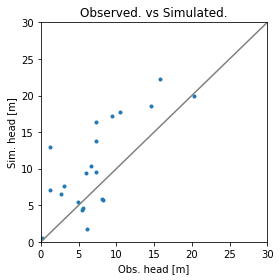

Error is - 8.79089455762944
Params are - [ 4.12311384 10.5567484   0.0962777   0.4440801   0.56023258  0.55157675
 -0.0341686   0.14858249  0.88080384  1.32538846  0.43579047]


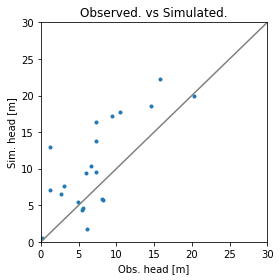

Error is - 8.79089455762944
Params are - [ 3.94371262  9.74219451  0.09371597  0.98310313  0.58948826  0.56605044
 -0.03520344  0.14720493  0.8852559   1.37496385  0.45673366]


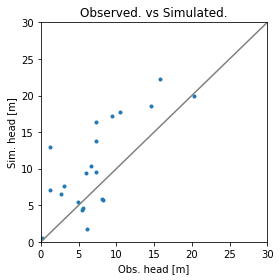

Error is - 8.79089455762944
Params are - [ 4.32722569 10.52764855  0.09239938  0.80135986  0.6298722   0.54802179
 -0.04403674  0.14534757  0.87557026  1.32044618  0.42650083]


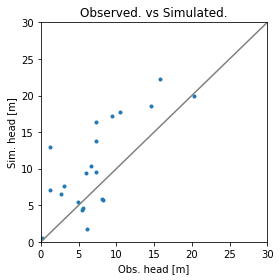

Error is - 8.79089455762944
Params are - [ 4.19302111 10.65260157  0.09333927  0.95614029  0.66904381  0.54318045
 -0.02144886  0.14481237  0.86633697  1.29176691  0.4263641 ]


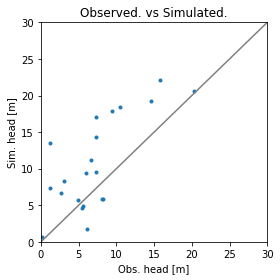

Error is - 8.767307560940305
Params are - [ 3.92461193 10.90250763  0.09521905  1.26570115  0.74738702  0.53349777
  0.02372691  0.14374196  0.8478704   1.23440838  0.42609065]


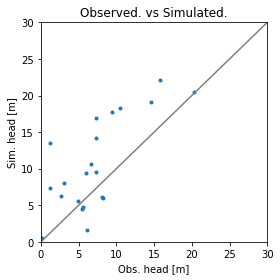

Error is - 8.814723800165096
Params are - [ 4.17044757 12.02388071  0.09511564  1.29011977  0.85565144  0.50470911
  0.0481961   0.14071976  0.82215411  1.1256559   0.39014963]


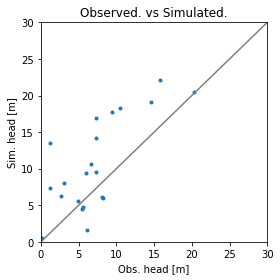

Error is - 8.814723800165096
Params are - [ 4.00039635 10.31261606  0.09406588  1.05985729  0.65602905  0.55071511
 -0.01435356  0.14558364  0.86948045  1.31263686  0.44008765]


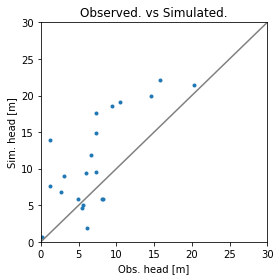

Error is - 8.749347716959983
Params are - [3.91192436e+00 1.06337051e+01 9.07329225e-02 1.14383559e+00
 6.16071453e-01 5.41808700e-01 1.00011598e-02 1.47010138e-01
 8.69645581e-01 1.26980130e+00 4.40565881e-01]


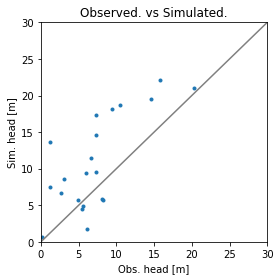

Error is - 8.737084228788351
Params are - [4.02746579e+00 1.12419512e+01 9.50004004e-02 1.06367154e+00
 6.91018374e-01 5.37486413e-01 6.81405729e-03 1.43349121e-01
 8.51434915e-01 1.24710194e+00 4.25026620e-01]


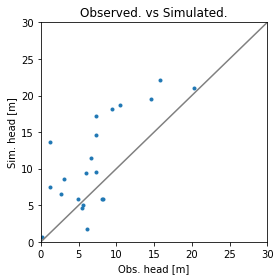

Error is - 8.745522837243513
Params are - [ 3.8503699  11.26284521  0.09224736  1.17672449  0.6936585   0.53838676
  0.01338491  0.14334525  0.85426983  1.25219439  0.42703555]


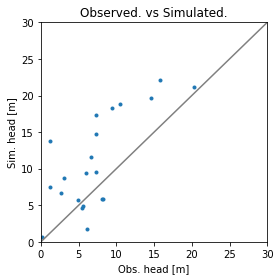

Error is - 8.754299786953567
Params are - [ 3.93106547 11.00900132  0.09381254  1.12266195  0.66444594  0.53659055
  0.01606282  0.14508574  0.85704867  1.25565524  0.42656074]


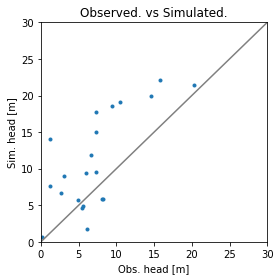

Error is - 8.764434088530525
Params are - [ 3.99513836 10.92447566  0.09240575  0.99841615  0.61114627  0.54306644
  0.01550416  0.1450488   0.86943683  1.2634573   0.41837418]


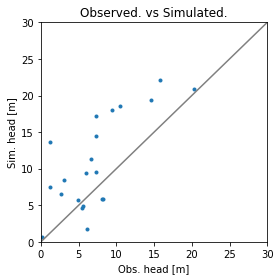

Error is - 8.762796913342873
Params are - [ 3.98528546 11.20553166  0.09248373  1.19354743  0.7135224   0.53493581
  0.02239457  0.1447929   0.84979359  1.23777011  0.41630274]


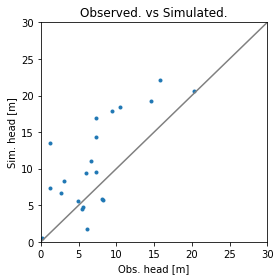

Error is - 8.754513029466203
Params are - [ 4.11921161 11.00547144  0.09448532  1.31288346  0.76290979  0.53213508
  0.01673112  0.1419714   0.83889028  1.23474306  0.413959  ]


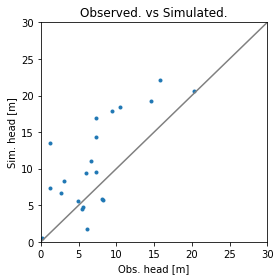

Error is - 8.754513029466203
Params are - [ 4.08514026e+00  1.10690026e+01  9.45746217e-02  8.93956332e-01
  6.20891278e-01  5.25669842e-01 -7.08276614e-03  1.46893489e-01
  8.68533258e-01  1.28015353e+00  4.27804420e-01]


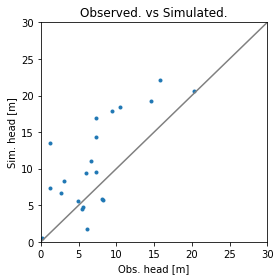

Error is - 8.754513029466203
Params are - [ 4.09685843e+00  1.06883286e+01  9.50295570e-02  1.04211696e+00
  6.46373273e-01  5.37454111e-01 -7.40096137e-03  1.45722871e-01
  8.60830447e-01  1.28074162e+00  4.23527990e-01]


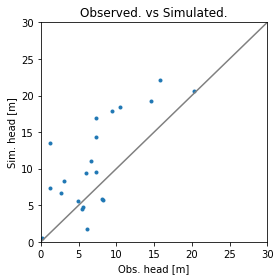

Error is - 8.754513029466203
Params are - [ 4.03031643 10.83612171  0.09434187  0.71185143  0.57086872  0.54563004
 -0.01288493  0.147506    0.87351539  1.30114528  0.43141065]


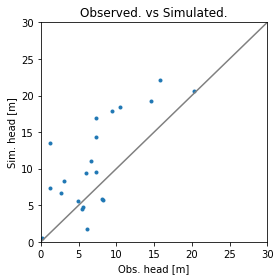

Error is - 8.754513029466203
Params are - [ 3.94061582 10.42884477  0.093061    0.98136294  0.58549655  0.55286689
 -0.01340235  0.14681722  0.87574142  1.32593298  0.44188224]


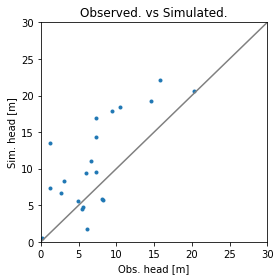

Error is - 8.754513029466203
Params are - [ 3.98954756e+00  1.09839423e+01  9.45352259e-02  1.11471746e+00
  6.88264847e-01  5.33778561e-01 -5.86481790e-03  1.45664592e-01
  8.51641413e-01  1.27511389e+00  4.36372484e-01]


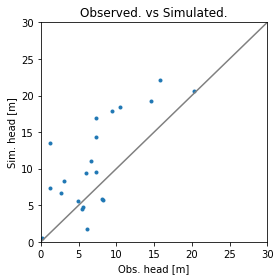

Error is - 8.754513029466203
Params are - [ 4.00017539 10.66259729  0.09483024  0.90525346  0.58129643  0.54169879
 -0.0178933   0.14607898  0.87162062  1.30759086  0.44209297]


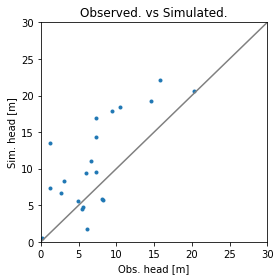

Error is - 8.754513029466203
Params are - [ 3.99645290e+00  1.07983309e+01  9.42436163e-02  9.77326954e-01
  6.14352926e-01  5.40008043e-01 -7.82133099e-03  1.45757460e-01
  8.66163865e-01  1.29013567e+00  4.35645412e-01]


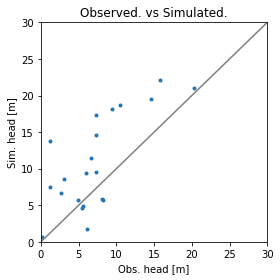

Error is - 8.744587817565886
Params are - [ 3.98900794 11.06979806  0.09307036  1.12147394  0.68046591  0.53662655
  0.0123226   0.14511442  0.85525035  1.2552253   0.4227503 ]


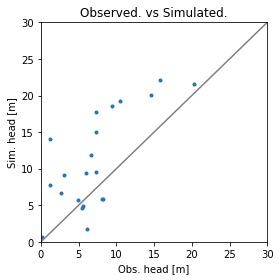

Error is - 8.760818733956706
Params are - [ 3.99581518 10.89979682  0.09251241  0.98531188  0.605136    0.54337385
  0.01367289  0.14510726  0.87042897  1.26663097  0.41954646]


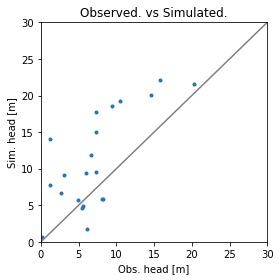

Error is - 8.760818733956706
Params are - [ 3.99111446e+00  1.09629059e+01  9.40295219e-02  1.08236607e+00
  6.67482634e-01  5.36177384e-01 -9.80390880e-04  1.45525258e-01
  8.56338301e-01  1.27299316e+00  4.32165979e-01]


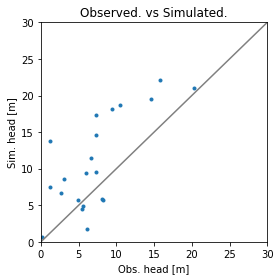

Error is - 8.740669243108146
Params are - [4.00823687e+00 1.11558746e+01 9.40353797e-02 1.09257274e+00
 6.85742140e-01 5.37056484e-01 9.56832865e-03 1.44231770e-01
 8.53342630e-01 1.25116362e+00 4.23888458e-01]


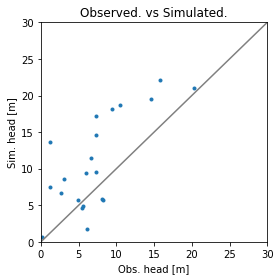

Error is - 8.74132059703126
Params are - [3.93891785e+00 1.12523982e+01 9.36238822e-02 1.12019802e+00
 6.92338439e-01 5.37936588e-01 1.00994830e-02 1.43347187e-01
 8.52852371e-01 1.24964817e+00 4.26031084e-01]


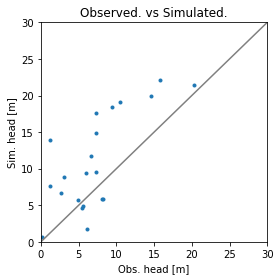

Error is - 8.737198757995168
Params are - [3.98249240e+00 1.11787231e+01 9.37032188e-02 1.02164715e+00
 6.36261613e-01 5.38584873e-01 7.60639829e-03 1.44889316e-01
 8.58830931e-01 1.26200203e+00 4.26028723e-01]


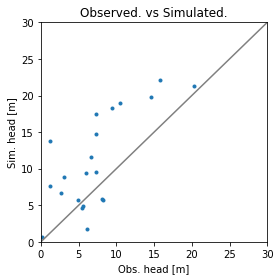

Error is - 8.740752112388073
Params are - [3.96969508e+00 1.09378282e+01 9.28666614e-02 1.10375357e+00
 6.53544913e-01 5.39647557e-01 8.40760856e-03 1.45179630e-01
 8.60540248e-01 1.25845162e+00 4.32796251e-01]


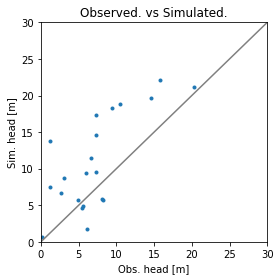

Error is - 8.744886779772282
Params are - [ 3.97926563 11.12547627  0.09440647  1.09316674  0.67773216  0.53703848
  0.01143844  0.14421743  0.85424179  1.25137859  0.42579368]


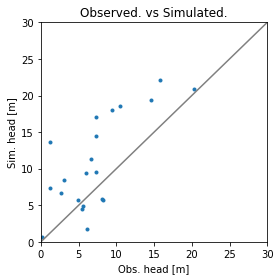

Error is - 8.7462334839866
Params are - [ 4.0733387  11.12371133  0.09474286  1.1882775   0.72696408  0.53481075
  0.01177259  0.14266026  0.8451626   1.2409225   0.41949281]


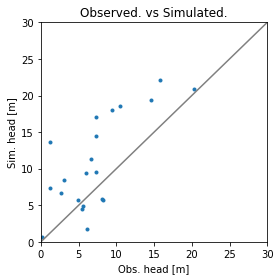

Error is - 8.7462334839866
Params are - [ 4.05630303e+00  1.11554769e+01  9.47875110e-02  9.78813936e-01
  6.55954826e-01  5.31578128e-01 -1.34354422e-04  1.45121305e-01
  8.59984087e-01  1.26362774e+00  4.26415520e-01]


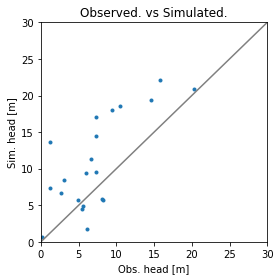

Error is - 8.7462334839866
Params are - [ 4.06216211e+00  1.09651399e+01  9.50149787e-02  1.05289425e+00
  6.68695823e-01  5.37470262e-01 -2.93452039e-04  1.44535996e-01
  8.56132681e-01  1.26392178e+00  4.24277305e-01]


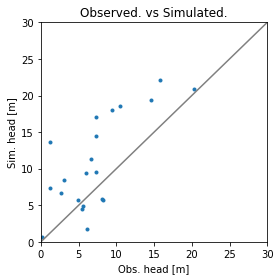

Error is - 8.7462334839866
Params are - [ 4.02889111e+00  1.10390365e+01  9.46711353e-02  8.87761483e-01
  6.30943546e-01  5.41558228e-01 -3.03543775e-03  1.45427562e-01
  8.62475155e-01  1.27412361e+00  4.28218635e-01]


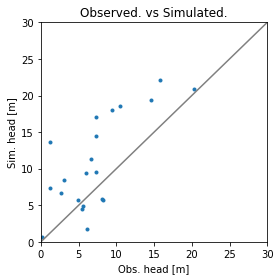

Error is - 8.7462334839866
Params are - [ 3.98404080e+00  1.08353980e+01  9.40307011e-02  1.02251724e+00
  6.38257464e-01  5.45176651e-01 -3.29414685e-03  1.45083172e-01
  8.63588168e-01  1.28651746e+00  4.33454431e-01]


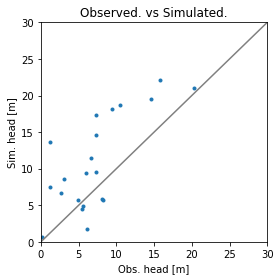

Error is - 8.72195385609089
Params are - [4.00850667e+00 1.11129467e+01 9.47678131e-02 1.08919450e+00
 6.89641610e-01 5.35632487e-01 4.74619697e-04 1.44506857e-01
 8.51538164e-01 1.26110792e+00 4.30699552e-01]


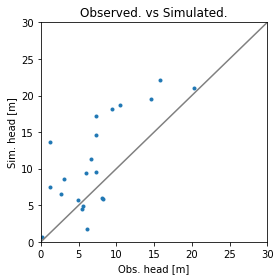

Error is - 8.754823982620344
Params are - [ 4.04055469 11.39888618  0.09462754  1.10329211  0.7088039   0.52915067
  0.01469747  0.14354709  0.84669103  1.226837    0.41903078]


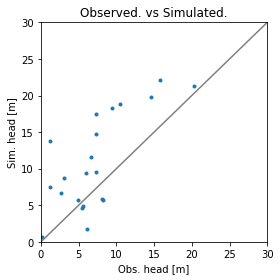

Error is - 8.71906487634302
Params are - [3.99816928e+00 1.09762700e+01 9.41799102e-02 1.04271096e+00
 6.55894074e-01 5.41170155e-01 1.20375750e-03 1.44699151e-01
 8.59363883e-01 1.27159735e+00 4.29848517e-01]


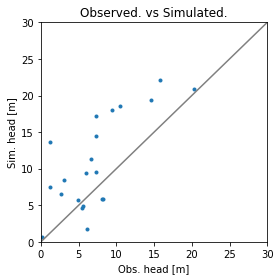

Error is - 8.751845818628086
Params are - [ 3.9901186  11.18383563  0.09389779  1.2662205   0.72065428  0.53269853
  0.01520952  0.14307026  0.84723835  1.23877153  0.42456291]


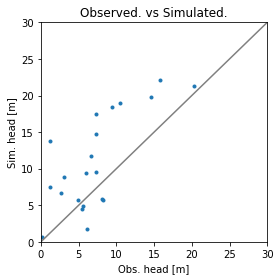

Error is - 8.72169170179804
Params are - [4.01919798e+00 1.10752363e+01 9.44777989e-02 9.82376237e-01
 6.53371230e-01 5.39343304e-01 1.52580275e-03 1.44838236e-01
 8.58665955e-01 1.26528559e+00 4.27304705e-01]


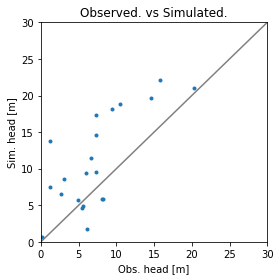

Error is - 8.74759165742468
Params are - [ 3.94903594 11.27774972  0.09345628  1.08826627  0.68011571  0.53712705
  0.01279831  0.14401678  0.85404142  1.24922132  0.42905468]


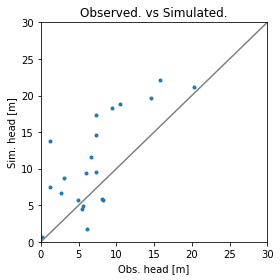

Error is - 8.726173366875368
Params are - [4.03388057e+00 1.10432924e+01 9.46253033e-02 1.06173726e+00
 6.71550796e-01 5.37384459e-01 2.97948900e-03 1.44406192e-01
 8.55609867e-01 1.26024667e+00 4.25471649e-01]


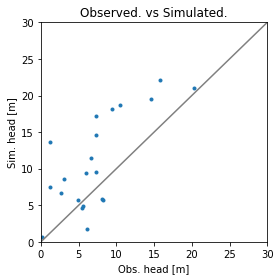

Error is - 8.747060491464142
Params are - [ 3.95081821 11.06701554  0.09365425  1.17742355  0.69569234  0.54407488
  0.01320537  0.14330145  0.84939471  1.24890063  0.42674485]


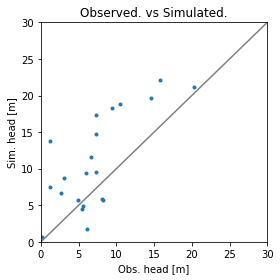

Error is - 8.726671552582344
Params are - [4.02993182e+00 1.11333616e+01 9.45041964e-02 1.02846634e+00
 6.65889205e-01 5.34702316e-01 3.20057615e-03 1.44666341e-01
 8.57336741e-01 1.25994596e+00 4.26497853e-01]


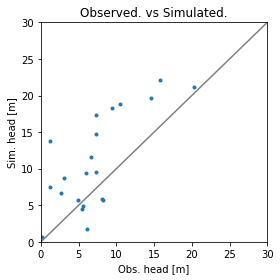

Error is - 8.726671552582344
Params are - [ 3.92589038e+00  1.11005357e+01  9.36555095e-02  9.38903418e-01
  6.13578563e-01  5.40822548e-01 -2.60123653e-04  1.46127234e-01
  8.66429676e-01  1.27506467e+00  4.34941206e-01]


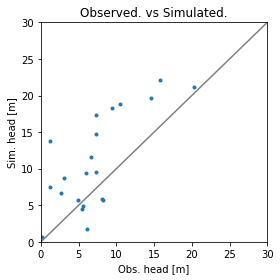

Error is - 8.726671552582344
Params are - [ 4.01025886e+00  1.10942361e+01  9.38553605e-02  1.00596630e+00
  6.51146201e-01  5.39282824e-01 -2.05298585e-03  1.44917305e-01
  8.59566456e-01  1.26891514e+00  4.30303525e-01]


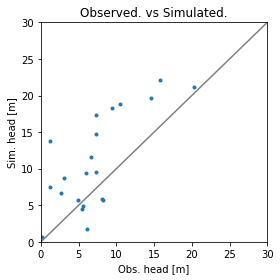

Error is - 8.726671552582344
Params are - [ 4.06357774e+00  1.09385574e+01  9.46800364e-02  9.58165619e-01
  6.29050419e-01  5.38629488e-01 -2.92356874e-03  1.46073023e-01
  8.62176623e-01  1.27414865e+00  4.30842926e-01]


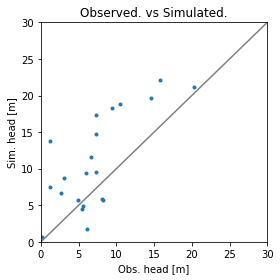

Error is - 8.726671552582344
Params are - [ 4.04987008e+00  1.12532600e+01  9.57669617e-02  9.48139533e-01
  6.63390401e-01  5.36733416e-01 -3.29190836e-03  1.44403015e-01
  8.54786269e-01  1.26819920e+00  4.23722610e-01]


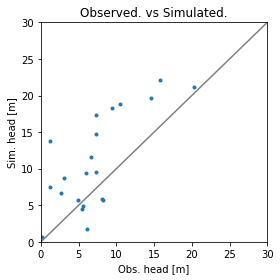

Error is - 8.726671552582344
Params are - [ 4.01889797e+00  1.10529200e+01  9.49130765e-02  9.33059778e-01
  6.27129221e-01  5.39265749e-01 -6.79085337e-03  1.45382010e-01
  8.62246366e-01  1.27858458e+00  4.32600248e-01]


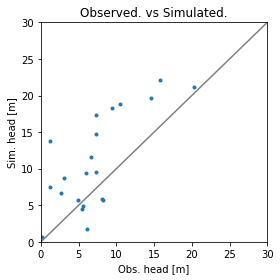

Error is - 8.726671552582344
Params are - [ 4.05126162e+00  1.10071982e+01  9.54652115e-02  9.87878578e-01
  6.74949313e-01  5.37861156e-01 -7.44660512e-03  1.44814045e-01
  8.57379054e-01  1.27076119e+00  4.31654806e-01]


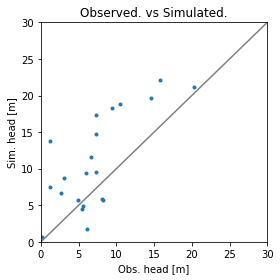

Error is - 8.726671552582344
Params are - [ 4.01061475e+00  1.09012878e+01  9.42525411e-02  9.32073644e-01
  6.17270905e-01  5.39027751e-01 -9.24711184e-03  1.46620590e-01
  8.65855822e-01  1.28996295e+00  4.33862034e-01]


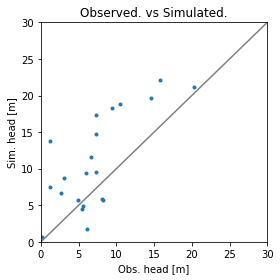

Error is - 8.726671552582344
Params are - [ 4.01482751e+00  1.09864536e+01  9.44395059e-02  9.64973118e-01
  6.35707772e-01  5.38642416e-01 -5.23181956e-03  1.45802723e-01
  8.62250595e-01  1.27924770e+00  4.31653181e-01]


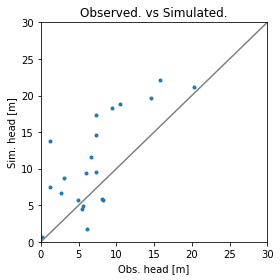

Error is - 8.726500612970508
Params are - [4.02325303e+00 1.11567854e+01 9.48134355e-02 1.03077207e+00
 6.72581506e-01 5.37871748e-01 2.79876501e-03 1.44166988e-01
 8.55040142e-01 1.25781720e+00 4.27235473e-01]


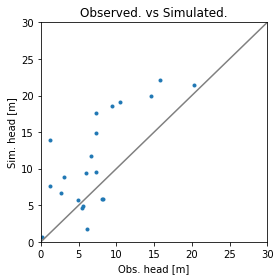

Error is - 8.735290241102408
Params are - [3.98172645e+00 1.11632384e+01 9.36692252e-02 1.01566542e+00
 6.32909455e-01 5.38654933e-01 6.87634514e-03 1.45038019e-01
 8.59486426e-01 1.26395025e+00 4.26430333e-01]


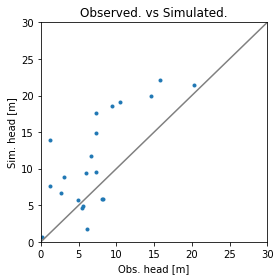

Error is - 8.735290241102408
Params are - [ 4.03387783e+00  1.10462083e+01  9.50162149e-02  9.94825289e-01
  6.64439348e-01  5.38059601e-01 -3.86586755e-03  1.44870039e-01
  8.57905897e-01  1.26905845e+00  4.30348688e-01]


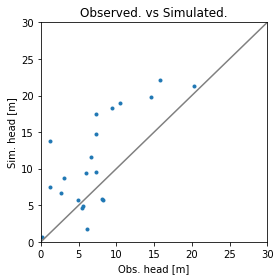

Error is - 8.72035620321128
Params are - [4.00868363e+00 1.10257532e+01 9.43288546e-02 1.01254360e+00
 6.54632652e-01 5.40256729e-01 1.36478013e-03 1.44768694e-01
 8.59014919e-01 1.26844147e+00 4.28576611e-01]


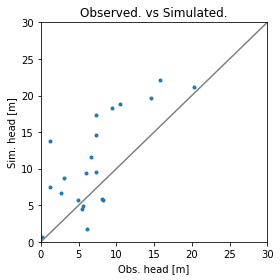

Error is - 8.720124546804378
Params are - [4.00333798e+00 1.10446084e+01 9.44738617e-02 1.06595273e+00
 6.72767842e-01 5.38401321e-01 8.39188601e-04 1.44603004e-01
 8.55451024e-01 1.26635263e+00 4.30274035e-01]


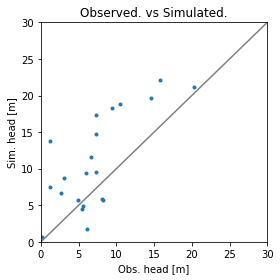

Error is - 8.72268468275293
Params are - [4.01602492e+00 1.10097812e+01 9.44026068e-02 1.05222411e+00
 6.63722435e-01 5.39277307e-01 2.09162325e-03 1.44552672e-01
 8.57486875e-01 1.26592201e+00 4.27660083e-01]


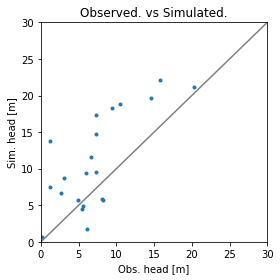

Error is - 8.722832797173952
Params are - [4.01071115e+00 1.10665277e+01 9.44966729e-02 1.03674151e+00
 6.64237790e-01 5.39520951e-01 2.00126126e-03 1.44433070e-01
 8.57202012e-01 1.26470727e+00 4.28541995e-01]


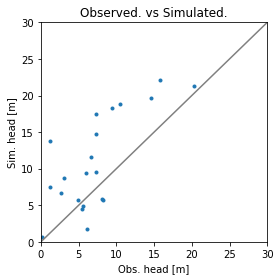

Error is - 8.722925365825732
Params are - [4.01405055e+00 1.10548158e+01 9.43420533e-02 1.03558865e+00
 6.60891639e-01 5.37936235e-01 2.20216683e-03 1.44682746e-01
 8.58350312e-01 1.26577165e+00 4.28173185e-01]


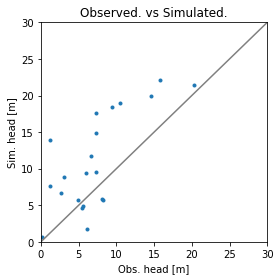

Error is - 8.716986711270529
Params are - [3.96202983e+00 1.10384029e+01 9.39177099e-02 9.90807188e-01
 6.34736318e-01 5.40996351e-01 4.71816926e-04 1.45413192e-01
 8.62896779e-01 1.27333101e+00 4.32394862e-01]


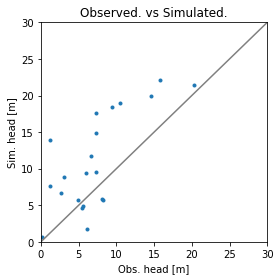

Error is - 8.716986711270529
Params are - [ 4.00421407e+00  1.10352531e+01  9.40176354e-02  1.02433863e+00
  6.53520137e-01  5.40226490e-01 -4.24614175e-04  1.44808228e-01
  8.59465170e-01  1.27025624e+00  4.30076021e-01]


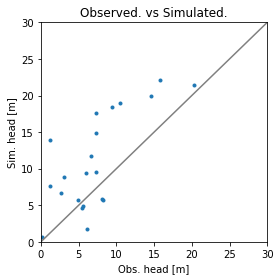

Error is - 8.716986711270529
Params are - [ 4.03087351e+00  1.09574137e+01  9.44299733e-02  1.00043829e+00
  6.42472247e-01  5.39899821e-01 -8.59905620e-04  1.45386087e-01
  8.60770253e-01  1.27287300e+00  4.30345722e-01]


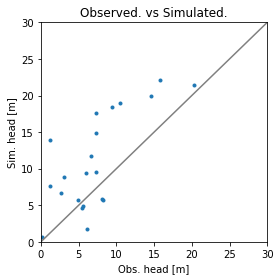

Error is - 8.716986711270529
Params are - [ 4.02401968e+00  1.11147650e+01  9.49734359e-02  9.95425245e-01
  6.59642237e-01  5.38951785e-01 -1.04407543e-03  1.44551083e-01
  8.57075076e-01  1.26989827e+00  4.26785564e-01]


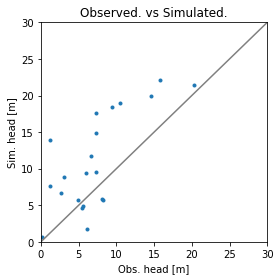

Error is - 8.716986711270529
Params are - [ 4.00853362e+00  1.10145950e+01  9.45464934e-02  9.87885368e-01
  6.41511647e-01  5.40217952e-01 -2.79354793e-03  1.45040581e-01
  8.60805124e-01  1.27509096e+00  4.31224383e-01]


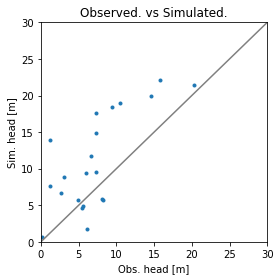

Error is - 8.716986711270529
Params are - [ 4.02471545e+00  1.09917341e+01  9.48225609e-02  1.01529477e+00
  6.65421693e-01  5.39515656e-01 -3.12142381e-03  1.44756598e-01
  8.58371468e-01  1.27117927e+00  4.30751662e-01]


 final_simplex: (array([[ 3.96202983e+00,  1.10384029e+01,  9.39177099e-02,
         9.90807188e-01,  6.34736318e-01,  5.40996351e-01,
         4.71816926e-04,  1.45413192e-01,  8.62896779e-01,
         1.27333101e+00,  4.32394862e-01],
       [ 4.00421407e+00,  1.10352531e+01,  9.40176354e-02,
         1.02433863e+00,  6.53520137e-01,  5.40226490e-01,
        -4.24614175e-04,  1.44808228e-01,  8.59465170e-01,
         1.27025624e+00,  4.30076021e-01],
       [ 4.03087351e+00,  1.09574137e+01,  9.44299733e-02,
         1.00043829e+00,  6.42472247e-01,  5.39899821e-01,
        -8.59905620e-04,  1.45386087e-01,  8.60770253e-01,
         1.27287300e+00,  4.30345722e-01],
       [ 4.02401968e+00,  1.11147650e+01,  9.49734359e-02,
         9.95425245e-01,  6.59642237e-01,  5.38951785e-01,
        -1.04407543e-03,  1.44551083e-01,  8.57075076e-01,
         1.26989827e+00,  4.26785564e-01],
       [ 4.00853362e+00,  1.10145950e+01,  9.45464934e-02,
         9.87885368e-01,  6.41511647e-01,  5

In [20]:
# run optimization 

params = [4.6, 13.0, 0.1, 5.0, 2.6, 0.4, 0.3, 0.1, 0.5, 0.6, 0.3]

results = opt.minimize(calibrateo, x0= params, method="Nelder-Mead",tol = 0.1)
results

In [25]:
Howd_we_do

,Obs_hed_m,Comp_hed_m,Residual_m
0,62.500000,25.301201,-37.198799
1,15.800000,24.927731,9.127730
2,1.200000,12.239455,11.039455
3,7.300000,12.926357,5.626357
4,7.300000,15.885945,8.585945
5,10.500000,17.590939,7.090939
6,9.450000,17.273735,7.823735
7,14.550000,18.844084,4.294084
8,20.299999,20.179035,-0.120964
9,1.200000,7.023807,5.823807
